Курсовая
Требования к курсовому:

Нужно будет оформить ноутбук с основными этапами:

подготовка данных
анализ
визуализация
обработка выбросов
обработка пропусков
генерация фичей
обучение модели
проверка качества модели
Так же надо отправить файл с предсказаниями на kaggle и на private leaderboard получить больше 0.6

Данные для курсового можно брать отсюда https://www.kaggle.com/t/b4c9382d4f934176af9fe860b1976528 (вкладка data)

За шаблон оформления курсовой можно взять ноутбук, который будем разбирать на уроке 10: https://www.kaggle.com/julichitai/baseline

Что обязательно стоит попробовать:

Тщательный анализ данных
Поиск странных значений
Предобработка данных
Генерация разнообразных признаков
Разные модели и их разные гиперпараметры
Что не стоит пробовать:

Кластеризация
Модели понижения размерности

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2

from sklearn.model_selection import GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
# from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.metrics import mean_squared_error , r2_score

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
pd.options.display.max_columns = 100 #настройка, чтобы можно было просматривать все столбцы датафрейма

In [5]:
# этот волшебный код убирает ненужные предупреждения об ошибках
import warnings
warnings.filterwarnings('ignore')

**Пути к директориям и файлам**

In [6]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

**Загрузка данных**

Описание датасета

Id - идентификационный номер квартиры
DistrictId - идентификационный номер района
Rooms - количество комнат
Square - площадь
LifeSquare - жилая площадь
KitchenSquare - площадь кухни
Floor - этаж
HouseFloor - количество этажей в доме
HouseYear - год постройки дома
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
Social_1, Social_2, Social_3 - социальные показатели местности
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
Price - цена квартиры

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [8]:
# поменяем типы 2х полей
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [10]:
train_df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

In [11]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [12]:
test_df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2'],
      dtype='object')

In [13]:
train_df.shape

(10000, 20)

In [14]:
test_df.shape

(5000, 19)

In [15]:
def graph_log(df_name, name, bins_):
    plt.figure(figsize = (16, 8))
    plt.yscale(value='log')
    df_name[name].hist(bins = bins_)
    plt.ylabel('Count')
    plt.xlabel(name)
    
    plt.title(name)
    plt.show()
    return

In [16]:
def graph(df_name, name, bins_):
    plt.figure(figsize = (16, 8))
   # plt.yscale(value='log')
    df_name[name].hist(bins = bins_)
    plt.ylabel('Count')
    plt.xlabel(name)
    
    plt.title(name)
    plt.show()
    return

1. EDA
Делаем EDA для:

Исправления выбросов

Заполнения NaN

Идей для генерации новых фич

Целевая переменная

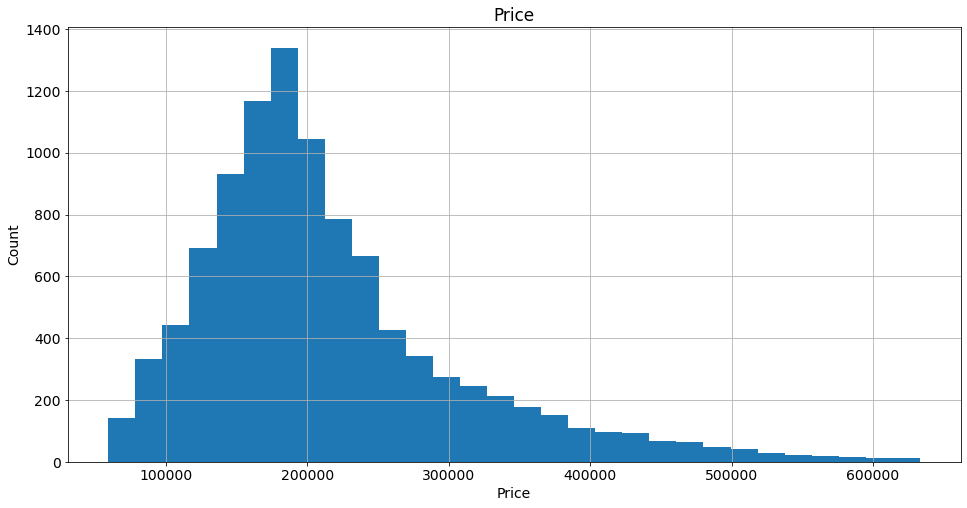

In [17]:
graph(train_df, 'Price', 30)

Количественные переменные

In [18]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Номинативные переменные

In [19]:
train_df.dtypes

Id                object
DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [20]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [21]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [22]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
174      1
196      1
209      1
117      1
Name: DistrictId, Length: 205, dtype: int64

In [23]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [24]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [25]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### 2. Обработка выбросов
Что можно делать с ними?

Выкинуть эти данные (только на трейне, на тесте ничего не выкидываем)
Заменять выбросы разными методами (медианы, средние значения, np.clip и т.д.)
Делать/не делать дополнительную фичу
Ничего не делать

#### Смотрим поле Rooms

In [26]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

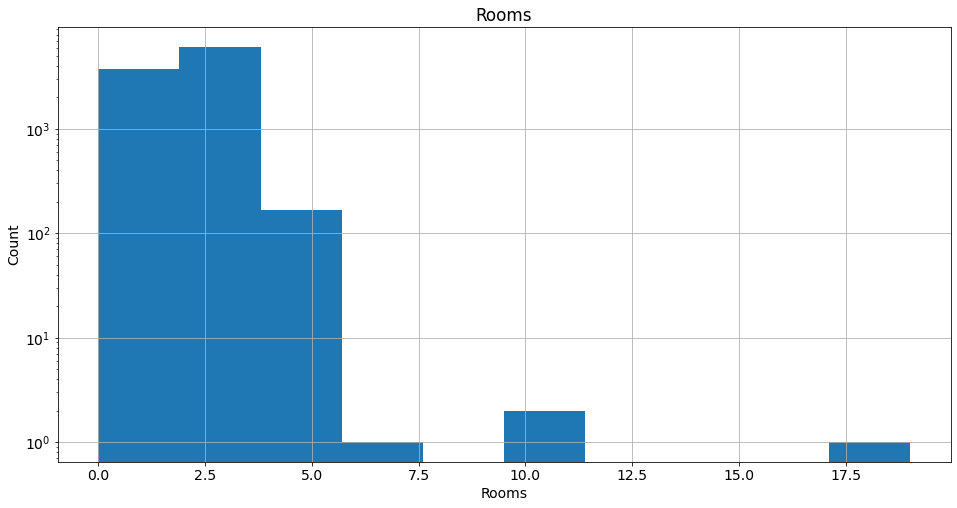

In [27]:
#визуализируем 
graph_log(train_df, 'Rooms', 10)

In [28]:
train_df.loc[(train_df['Rooms'] <= 0) | (train_df['Rooms'] > 5)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2004,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
2728,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863
3780,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
5894,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
6088,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
6401,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007
7644,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
7929,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
8794,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416


In [29]:
# Создаем вспомогательный столбец с признаком выброса
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] <= 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [30]:
train_df['Rooms_outlier'].value_counts()

0    9988
1      12
Name: Rooms_outlier, dtype: int64

In [31]:
train_df['Rooms'].describe()

count    10000.000000
mean         1.890500
std          0.839512
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

In [32]:
train_df['Rooms'].mean()

1.8905

In [33]:
train_df['Rooms'].value_counts(bins=6)

(-0.02, 3.167]      9828
(3.167, 6.333]       169
(9.5, 12.667]          2
(15.833, 19.0]         1
(12.667, 15.833]       0
(6.333, 9.5]           0
Name: Rooms, dtype: int64

In [34]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Смотрим как скорректировать ['Rooms'] == 0

In [35]:
train_df[(train_df['Rooms'] <= 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646,1
3780,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788,1
5894,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463,1
6401,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007,1
7644,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887,1
7929,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112,1
9767,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389,1
9869,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798,1


In [36]:
train_df[(train_df['Square'] > 200) & (train_df['Rooms'] != 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
726,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538,0
1776,16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.506016,0
1906,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666,0
7010,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830,0
9229,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562,0


In [37]:
round(train_df.loc[(train_df['Square'] > 200) & (train_df['Rooms'] != 0), 'Rooms'].mean())

3

In [38]:
# присваиваем среднее количество комнат 3 для площади больше 200
train_df.loc[(train_df['Square'] > 200) & (train_df['Rooms'] <= 0), 'Rooms'] = round(train_df.loc[(train_df['Square'] > 200) & (train_df['Rooms'] != 0), 'Rooms'].mean())

In [39]:
# смотрим, что получилось
train_df[train_df['Id'] == '7917']

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
7644,7917,27,3.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887,1


In [40]:
train_df[(train_df['Rooms'] <= 0) & (train_df['Square'] <= 55)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646,1
3780,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788,1
5894,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463,1
9869,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798,1


In [41]:
round(train_df.loc[(train_df['Square'] <= 55), 'Rooms'].mean())

1

In [42]:
# присваиваем среднее количество комнат 1 для площади меньше 55
train_df.loc[(train_df['Rooms'] <= 0) & (train_df['Square'] <= 55), 'Rooms'] = round(train_df.loc[(train_df['Square'] <= 55), 'Rooms'].mean())

In [43]:
# смотрим, что получилось
train_df[train_df['Id'] == '3159']

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
2194,3159,88,1.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646,1


In [44]:
train_df[(train_df['Rooms'] <= 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
6401,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007,1
7929,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112,1
9767,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389,1


In [45]:
round(train_df.loc[(train_df['Square'] > 55) & (train_df['Square'] <= 100), 'Rooms'].mean())

2

In [46]:
# присваиваем среднее количество комнат 2 для площади от 55 до 100
train_df.loc[(train_df['Rooms'] <= 0) & (train_df['Square'] <= 100), 'Rooms'] = round(train_df.loc[(train_df['Square'] > 55) & (train_df['Square'] <= 100), 'Rooms'].mean()) 

In [47]:
round(train_df.loc[(train_df['Square'] > 100) & (train_df['Square'] <= 150), 'Rooms'].mean())

3

In [48]:
# присваиваем среднее количество комнат 3 для площади от 55 до 100
train_df.loc[(train_df['Rooms'] <= 0) & (train_df['Square'] <= 150), 'Rooms'] = round(train_df.loc[(train_df['Square'] > 100) & (train_df['Square'] <= 150), 'Rooms'].mean()) 

Всё с нулевым кол-вом комнат разобрался

In [49]:
train_df[train_df['Rooms'] >= 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
2004,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792,1
2728,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863,1
6088,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704,1
8794,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416,1


Только посмотрите на эти выбросы, тут явная ошибка в комнатах. Судя по площади, тут везде 1 комната.

In [50]:
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = 1

In [51]:
# смотрим, что получилось
train_df[train_df['Id'] == '14003']

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
8794,14003,99,1.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416,1


In [52]:
train_df['Rooms'].value_counts()

2.0    3882
1.0    3713
3.0    2237
4.0     150
5.0      18
Name: Rooms, dtype: int64

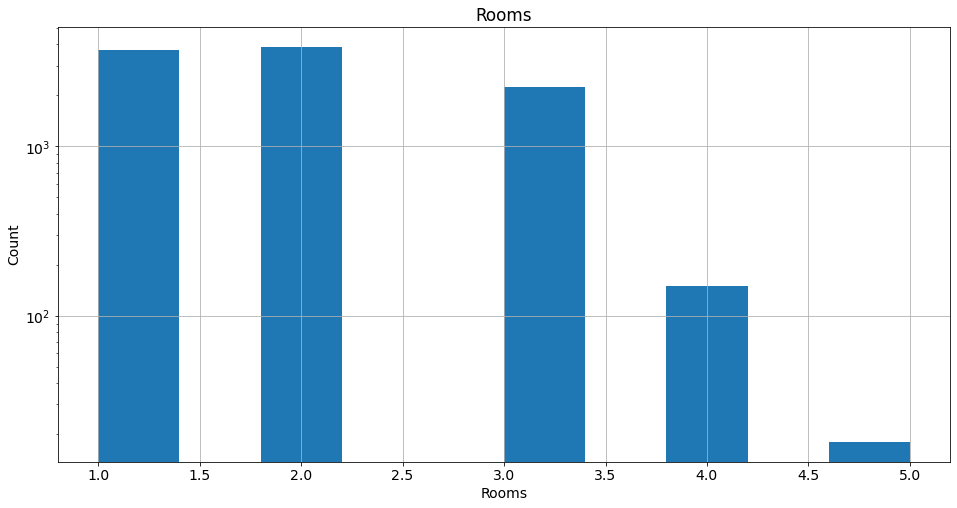

In [53]:
#визуализируем 
graph_log(train_df, 'Rooms', 10)

Смотрим признак KitchenSquare

In [54]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0         2
30.0         2
51.0         2
40.0         1
96.0         1
48.0         1
72.0         1
73.0         1
2014.0       1
66.0         1
36.0         1
78.0         1
54.0         1
29.0         1
31.0         1
35.0         1
62.0         1
39.0         1
1970.0       1
60.0         1
75.0         1
26.0         1
21.0         1
84.0         1
63.0         1
123.0        1
53.0         1
42.0         1
23.0         1
27.0         1
Name: KitchenSquare, dtype: int64

In [55]:
train_df['KitchenSquare_outlier'] = 0

In [56]:
train_df['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [57]:
train_df['KitchenSquare'].median()

6.0

In [58]:
train_df['KitchenSquare'].quantile(.975)

13.0

In [59]:
train_df['KitchenSquare'].quantile(.025)

0.0

In [60]:
condition_1 = train_df['KitchenSquare'] >= train_df['KitchenSquare'].quantile(.975)

In [61]:
train_df['KitchenSquare'][condition_1]

12      13.0
55      13.0
85      14.0
136     13.0
158     16.0
        ... 
9810    19.0
9860    25.0
9867    13.0
9935    13.0
9937    20.0
Name: KitchenSquare, Length: 256, dtype: float64

In [62]:
train_df.loc[train_df['KitchenSquare']<5, 'KitchenSquare']

3       1.0
8       1.0
9       1.0
18      1.0
19      1.0
       ... 
9982    1.0
9983    1.0
9990    2.0
9991    0.0
9993    0.0
Name: KitchenSquare, Length: 3222, dtype: float64

In [63]:
# заполнили поле KitchenSquare_outlier
train_df.loc[(train_df['KitchenSquare'] > 30), 'KitchenSquare_outlier'] = 1

In [64]:
# замедианим то, что больше 30
train_df.loc[(train_df['KitchenSquare'] > 30), 'KitchenSquare'] = train_df['KitchenSquare'].median()

In [65]:
# заполнили поле KitchenSquare_outlier
train_df.loc[(train_df['KitchenSquare'] < 4), 'KitchenSquare_outlier'] = 1

In [66]:
# замедианим то, что меньше 4
train_df.loc[(train_df['KitchenSquare'] < 4), 'KitchenSquare'] = train_df['KitchenSquare'].median()

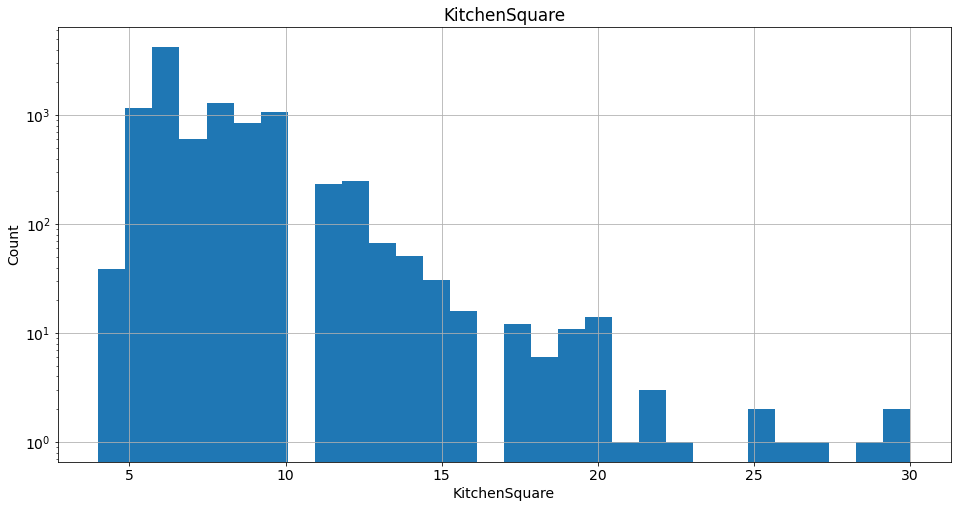

In [67]:
graph_log(train_df, 'KitchenSquare', 30)

In [68]:
train_df['KitchenSquare'].value_counts()

6.0     4257
8.0     1306
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
14.0      51
4.0       39
15.0      31
16.0      16
20.0      14
17.0      12
19.0      11
18.0       6
22.0       3
25.0       2
30.0       2
26.0       1
29.0       1
23.0       1
21.0       1
27.0       1
Name: KitchenSquare, dtype: int64

In [69]:
train_df['KitchenSquare_outlier'].value_counts()

0    6781
1    3219
Name: KitchenSquare_outlier, dtype: int64

In [70]:
train_df['KitchenSquare'].median()

6.0

Смотрим поле Square

In [71]:
train_df[['Square']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Square  10000 non-null  float64
dtypes: float64(1)
memory usage: 78.2 KB


In [72]:
train_df['Square'].describe()

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

In [73]:
train_df['Square'].value_counts(bins=20)

(33.133, 65.13]       6978
(65.13, 97.126]       2339
(0.496, 33.133]        372
(97.126, 129.123]      257
(129.123, 161.119]      32
(161.119, 193.115]      15
(193.115, 225.112]       3
(577.072, 609.069]       1
(257.108, 289.105]       1
(609.069, 641.065]       1
(385.094, 417.09]        1
(321.101, 353.097]       0
(353.097, 385.094]       0
(225.112, 257.108]       0
(417.09, 449.087]        0
(449.087, 481.083]       0
(481.083, 513.08]        0
(513.08, 545.076]        0
(545.076, 577.072]       0
(289.105, 321.101]       0
Name: Square, dtype: int64

In [74]:
train_df[train_df['Square'] > 300]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier
726,28,9,2.0,604.705972,NaN,6.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538,0,1
7010,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830,0,0
9229,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562,0,0


In [75]:
train_df['Square_outlier'] = 0

In [76]:
train_df['LifeSquare_outlier'] = 0

In [77]:
train_df.loc[(train_df['Square'] > 300), 'Square_outlier'] = 1
train_df.loc[(train_df['Square'] > 300), 'LifeSquare_outlier'] = 1

In [78]:
train_df.loc[(train_df['Square'] > 300), 'Square'] = train_df['Square']/10 #делим выбросы на 10, т.к. похоже, что шиблись в запятой

In [79]:
train_df.loc[(train_df['Square'] > 300), 'LifeSquare'] = train_df['LifeSquare']/10

In [80]:
train_df[train_df['Square'] > 200] # оставим как есть, такое вполне может быть

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier
1776,16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.506016,0,0,0,0
1906,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666,0,0,0,0
7644,7917,27,3.0,212.932361,211.231125,6.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887,1,1,0,0


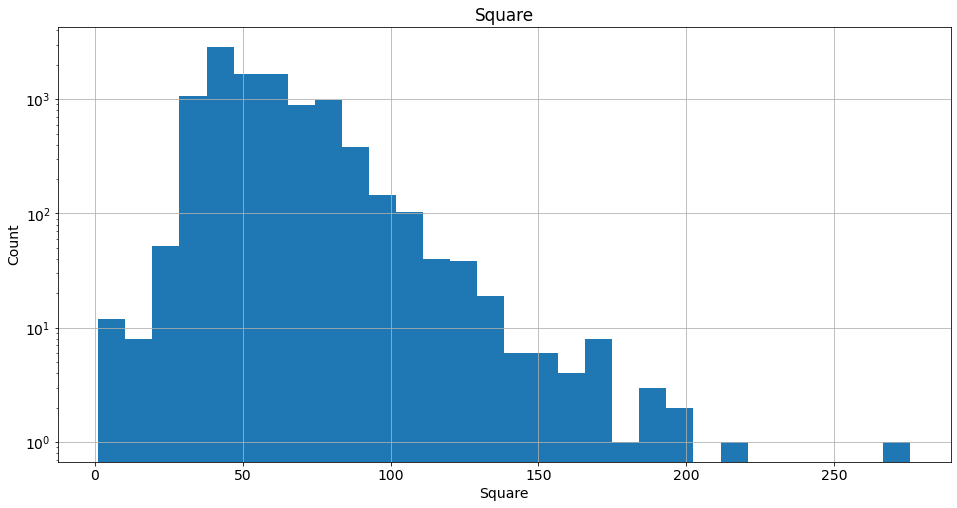

In [81]:
graph_log(train_df, 'Square', 30)

In [82]:
train_df['Square'].quantile(.975) #обрубать  по этой квантили не вижу смысла, квартир больше 100 м полным-полно

100.58428965502168

In [83]:
train_df['Square'].quantile(.0021)

20.212527740488536

In [84]:
train_df[(train_df['Square'] < 20) & (train_df['Rooms'] > 1)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier
328,4504,27,3.0,4.390331,5.610772,6.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034,0,1,0,0
3686,15877,57,3.0,16.547242,16.698571,8.0,5,5.0,1962,0.133215,B,B,49,11395,3,1406.0,3,4,A,77835.185808,0,0,0,0
7033,1748,88,2.0,5.497061,67.628717,6.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764,0,1,0,0
8501,12927,62,2.0,17.414181,NaN,6.0,4,20.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,180750.471749,0,1,0,0
9067,13265,1,3.0,4.823679,79.767964,6.0,6,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.681261,0,1,0,0
9286,12676,81,3.0,13.784865,15.988889,7.0,4,5.0,1960,0.319809,B,B,25,4756,16,2857.0,5,8,B,78388.806186,0,0,0,0


In [85]:
train_df.loc[(train_df['Square'] < 20) & (train_df['Rooms'] > 1), 'Square_outlier'] = 1
train_df.loc[(train_df['Square'] < 20) & (train_df['Rooms'] > 1), 'LifeSquare_outlier'] = 1

In [86]:
# Создадим поле DELETE Там отметим все подозрительные строки, в достоверности которых я сильно сомневаюсь
train_df['DELETE'] = 0

In [87]:
train_df.loc[(train_df['Square'] < 20) & (train_df['Rooms'] > 1), 'DELETE'] = 1

In [88]:
# Для порядка скорректируем кол-во комнат в квартирах < 20 м
train_df.loc[(train_df['Square'] < 20) & (train_df['Rooms'] > 1), 'Rooms'] = 1

In [89]:
train_df[(train_df['Square'] < 15)] 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE
161,6782,45,1.0,2.954309,5.257278,6.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.182323,0,1,0,0,0
328,4504,27,1.0,4.390331,5.610772,6.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034,0,1,1,1,1
1401,9487,5,1.0,5.129222,5.549458,6.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061,0,1,0,0,0
4496,15744,34,1.0,1.988943,2.642219,6.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006,0,1,0,0,0
4800,7657,38,1.0,4.502784,4.618547,6.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.488083,0,1,0,0,0
5009,11526,27,1.0,4.633498,1.969969,6.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441,0,1,0,0,0
7033,1748,88,1.0,5.497061,67.628717,6.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764,0,1,1,1,1
7470,14786,1,1.0,1.136859,4.525736,6.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.825589,0,1,0,0,0
8572,10202,6,1.0,2.596351,4.604943,6.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458,0,1,0,0,0
8805,10527,27,1.0,4.380726,40.805837,6.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.720383,0,1,0,0,0


In [90]:
# делать с этими квартирами < 15 м ничего не будем, но запишем их в поле DELETE
train_df.loc[(train_df['Square'] < 15), 'DELETE'] = 1



Смотрим критерий LifeSquare

In [91]:
train_df[train_df['LifeSquare'] > train_df['Square']] # 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE
33,847,74,2.0,73.314975,74.131261,6.0,7,6.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,254005.381863,0,1,0,0,0
64,3992,1,3.0,87.200625,87.730225,6.0,21,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,300180.365669,0,1,0,0,0
77,11771,45,1.0,38.467276,39.624493,6.0,11,9.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,247440.530601,0,1,0,0,0
100,13343,74,2.0,79.937665,82.931595,6.0,8,21.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,226808.747168,0,1,0,0,0
111,13875,20,1.0,28.438794,32.514021,6.0,6,10.0,2014,0.019509,B,B,37,7687,11,176.0,5,5,B,199248.114376,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056784,98.152802,6.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705,0,1,0,0,0
9962,14175,14,1.0,42.029175,44.682167,10.0,4,4.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,87556.385617,0,0,0,0,0
9979,2201,6,1.0,40.043234,41.984322,6.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,134888.083598,0,1,0,0,0
9987,11665,1,2.0,62.690057,64.602939,10.0,19,22.0,2018,0.007122,B,B,1,264,0,NaN,0,1,B,203908.192698,0,0,0,0,0


In [92]:
train_df['test'] = 0

In [93]:
train_df.loc[(train_df['LifeSquare'] > train_df['Square']),('LifeSquare')] = (train_df['Square'] - train_df['KitchenSquare'])

In [94]:
train_df.loc[(train_df['LifeSquare'] > 300), 'LifeSquare'] = train_df['LifeSquare']/10

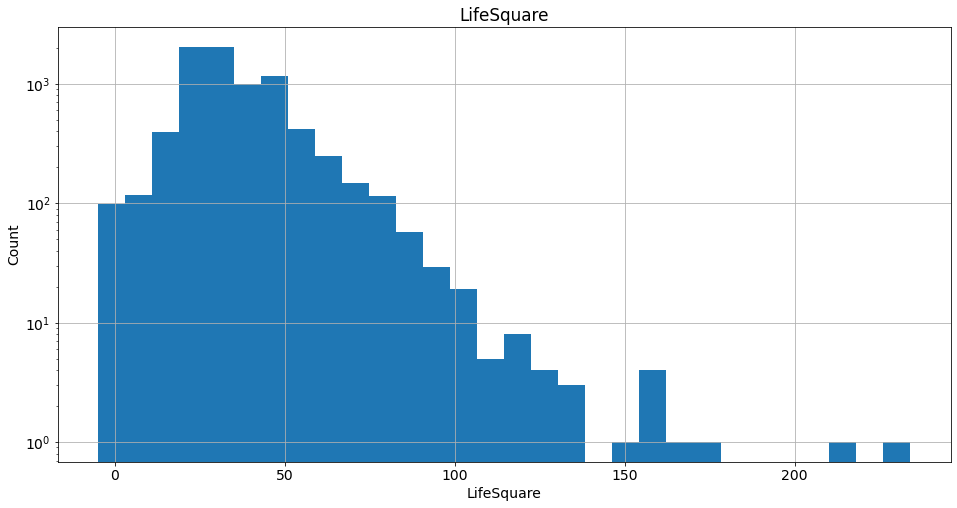

In [95]:
#визуализируем 
graph_log(train_df, 'LifeSquare', 30)

In [96]:
train_df['LifeSquare'].value_counts(bins=6)

(-5.103000000000001, 34.939]    4658
(34.939, 74.741]                2980
(74.741, 114.543]                225
(114.543, 154.345]                16
(154.345, 194.147]                 6
(194.147, 233.949]                 2
Name: LifeSquare, dtype: int64

In [97]:
train_df[train_df['LifeSquare'] < 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test
161,6782,45,1.0,2.954309,-3.045691,6.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.182323,0,1,0,0,1,0
328,4504,27,1.0,4.390331,-1.609669,6.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034,0,1,1,1,1,0
1401,9487,5,1.0,5.129222,-0.870778,6.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061,0,1,0,0,1,0
4496,15744,34,1.0,1.988943,-4.011057,6.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006,0,1,0,0,1,0
4800,7657,38,1.0,4.502784,-1.497216,6.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.488083,0,1,0,0,1,0
7033,1748,88,1.0,5.497061,-0.502939,6.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764,0,1,1,1,1,0
7470,14786,1,1.0,1.136859,-4.863141,6.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.825589,0,1,0,0,1,0
8572,10202,6,1.0,2.596351,-3.403649,6.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458,0,1,0,0,1,0
8805,10527,27,1.0,4.380726,-1.619274,6.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.720383,0,1,0,0,1,0
9067,13265,1,1.0,4.823679,-1.176321,6.0,6,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.681261,0,1,1,1,1,0


In [98]:
train_df.loc[161]

Id                           6782
DistrictId                     45
Rooms                           1
Square                    2.95431
LifeSquare               -3.04569
KitchenSquare                   6
Floor                           3
HouseFloor                      1
HouseYear                    1977
Ecology_1                0.195781
Ecology_2                       B
Ecology_3                       B
Social_1                       23
Social_2                     5212
Social_3                        6
Healthcare_1                  NaN
Helthcare_2                     3
Shops_1                         2
Shops_2                         B
Price                      438005
Rooms_outlier                   0
KitchenSquare_outlier           1
Square_outlier                  0
LifeSquare_outlier              0
DELETE                          1
test                            0
Name: 161, dtype: object

In [99]:
train_df.loc[(train_df['LifeSquare'] < 10), 'LifeSquare_outlier'] = 1

In [100]:
train_df.loc[(train_df['LifeSquare'] < 10), 'LifeSquare'] = (train_df['Square'] - train_df['KitchenSquare'])

In [101]:
train_df.loc[(train_df['LifeSquare'] < 10)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test
161,6782,45,1.0,2.954309,-3.045691,6.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.182323,0,1,0,1,1,0
328,4504,27,1.0,4.390331,-1.609669,6.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034,0,1,1,1,1,0
1401,9487,5,1.0,5.129222,-0.870778,6.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061,0,1,0,1,1,0
3686,15877,57,1.0,16.547242,8.547242,8.0,5,5.0,1962,0.133215,B,B,49,11395,3,1406.0,3,4,A,77835.185808,0,0,1,1,1,0
4496,15744,34,1.0,1.988943,-4.011057,6.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006,0,1,0,1,1,0
4800,7657,38,1.0,4.502784,-1.497216,6.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.488083,0,1,0,1,1,0
5009,11526,27,1.0,4.633498,-1.366502,6.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441,0,1,0,1,1,0
7033,1748,88,1.0,5.497061,-0.502939,6.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764,0,1,1,1,1,0
7470,14786,1,1.0,1.136859,-4.863141,6.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.825589,0,1,0,1,1,0
8572,10202,6,1.0,2.596351,-3.403649,6.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458,0,1,0,1,1,0


In [102]:
train_df[pd.isnull(train_df['LifeSquare'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,0,0,0,0,0,0
3,2352,1,1.0,40.409907,NaN,6.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,0,1,0,0,0,0
18,4581,1,1.0,47.582480,NaN,6.0,16,16.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,128803.593810,0,1,0,0,0,0
20,8768,63,1.0,50.974891,NaN,6.0,7,16.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,260328.413376,0,1,0,0,0,0
24,4717,27,1.0,44.203947,NaN,6.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975,4944,6,2.0,52.573133,NaN,6.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,154366.031184,0,1,0,0,0,0
9978,4851,1,1.0,39.314342,NaN,6.0,13,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,137782.941940,0,1,0,0,0,0
9981,6753,62,2.0,73.092686,NaN,6.0,4,16.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,159077.198056,0,1,0,0,0,0
9983,647,1,2.0,63.324025,NaN,6.0,4,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,183809.327114,0,1,0,0,0,0


In [103]:
train_df.loc[pd.isnull(train_df['LifeSquare']), 'LifeSquare_outlier'] = 1

In [104]:
train_df.loc[pd.isnull(train_df['LifeSquare']), 'LifeSquare'] = train_df['Square']-train_df['KitchenSquare']

In [105]:
train_df[train_df['Id'] == '11809']

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test
0,11809,27,3.0,115.027311,105.027311,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,0,0,0,1,0,0


In [106]:
train_df.loc[(train_df['LifeSquare'] <= 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test
161,6782,45,1.0,2.954309,-3.045691,6.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.182323,0,1,0,1,1,0
328,4504,27,1.0,4.390331,-1.609669,6.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034,0,1,1,1,1,0
1401,9487,5,1.0,5.129222,-0.870778,6.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061,0,1,0,1,1,0
4496,15744,34,1.0,1.988943,-4.011057,6.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006,0,1,0,1,1,0
4800,7657,38,1.0,4.502784,-1.497216,6.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.488083,0,1,0,1,1,0
5009,11526,27,1.0,4.633498,-1.366502,6.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441,0,1,0,1,1,0
7033,1748,88,1.0,5.497061,-0.502939,6.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764,0,1,1,1,1,0
7470,14786,1,1.0,1.136859,-4.863141,6.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.825589,0,1,0,1,1,0
8572,10202,6,1.0,2.596351,-3.403649,6.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458,0,1,0,1,1,0
8805,10527,27,1.0,4.380726,-1.619274,6.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.720383,0,1,0,1,1,0


In [107]:
train_df.loc[train_df['LifeSquare'] < 0, 'DELETE'] = 1

In [108]:
train_df.loc[train_df['LifeSquare'] < 0, 'LifeSquare_outlier'] = 1

In [109]:
train_df.loc[train_df['LifeSquare'] < 0, 'LifeSquare'] = train_df['LifeSquare'] * (-1)

In [110]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     10000 non-null  object 
 1   DistrictId             10000 non-null  object 
 2   Rooms                  10000 non-null  float64
 3   Square                 10000 non-null  float64
 4   LifeSquare             10000 non-null  float64
 5   KitchenSquare          10000 non-null  float64
 6   Floor                  10000 non-null  int64  
 7   HouseFloor             10000 non-null  float64
 8   HouseYear              10000 non-null  int64  
 9   Ecology_1              10000 non-null  float64
 10  Ecology_2              10000 non-null  object 
 11  Ecology_3              10000 non-null  object 
 12  Social_1               10000 non-null  int64  
 13  Social_2               10000 non-null  int64  
 14  Social_3               10000 non-null  int64  
 15  Hea

Смотрим Floor

In [111]:
train_df[['Floor']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Floor   10000 non-null  int64
dtypes: int64(1)
memory usage: 78.2 KB


In [112]:
train_df['Floor'].value_counts()

4     949
5     876
3     872
6     802
7     759
8     643
9     604
2     588
10    553
11    457
12    438
13    398
14    362
16    290
15    287
17    256
1     235
18    185
19    121
20     68
21     59
22     54
24     53
25     34
23     25
26     18
27      5
28      3
32      2
42      1
33      1
37      1
31      1
Name: Floor, dtype: int64

In [113]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [114]:
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']) & (train_df['HouseFloor'] < 5)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test
24,4717,27,1.0,44.203947,38.203947,6.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958,0,1,0,1,0,0
25,4521,6,2.0,65.409965,59.409965,6.0,18,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,191205.272608,0,1,0,1,0,0
26,8553,88,3.0,83.262530,77.262530,6.0,13,1.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,410883.892020,0,1,0,1,0,0
44,9024,6,3.0,79.790762,73.790762,6.0,16,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,193595.800511,0,1,0,1,0,0
47,6186,1,1.0,62.006079,56.006079,6.0,7,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,197006.124188,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9938,2913,34,4.0,94.888593,88.888593,6.0,4,1.0,2018,0.069753,B,B,53,13670,4,NaN,1,11,B,346949.506507,0,1,0,1,0,0
9940,4711,6,1.0,41.224118,35.224118,6.0,8,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,125612.639104,0,1,0,1,0,0
9950,5383,48,3.0,98.994909,92.994909,6.0,3,0.0,1977,0.041125,B,B,46,9515,5,NaN,1,10,B,418817.004446,0,1,0,1,0,0
9960,16258,48,3.0,96.056784,90.056784,6.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705,0,1,0,0,0,0


In [115]:
train_df['Floor_outlier'] = 0

In [116]:
train_df['HouseFloor_outlier'] = 0

In [117]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor_outlier'] = 1

In [118]:
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']) & (train_df['HouseFloor'] < 5), 'HouseFloor_outlier'] = 1 

In [119]:
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']) & (train_df['HouseFloor'] < 5), 'HouseFloor'].value_counts()

1.0    484
0.0    269
3.0     63
4.0     41
2.0     30
Name: HouseFloor, dtype: int64

In [120]:
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']) & (train_df['HouseFloor'] < 5), 'HouseFloor'] = train_df.loc[(train_df['Floor'] > train_df['HouseFloor']) & (train_df['HouseFloor'] < 5), 'Floor']

In [121]:
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']), 'Floor'] = train_df['HouseFloor']

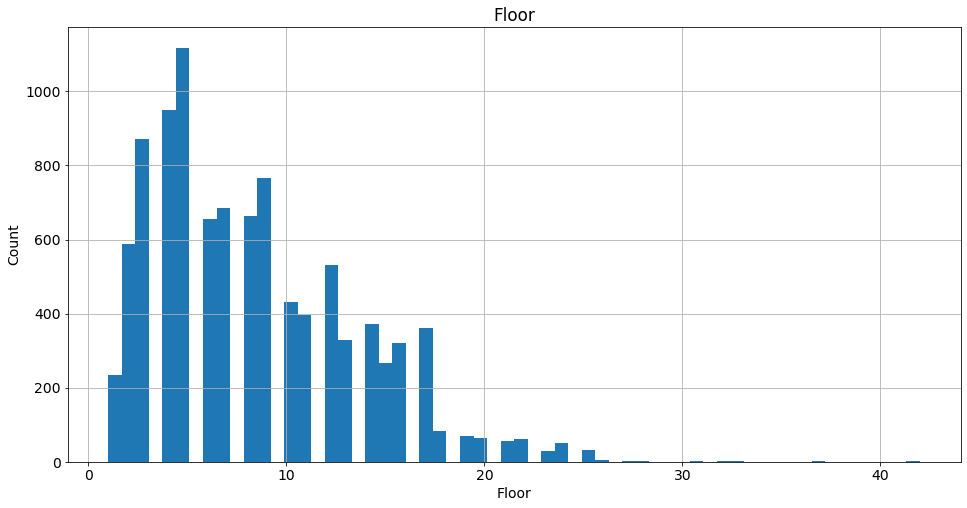

In [122]:
#визуализируем 
graph(train_df, 'Floor', 60)

In [123]:
train_df['Floor'].value_counts()

5.0     1118
4.0      949
3.0      872
9.0      765
7.0      684
8.0      663
6.0      656
2.0      588
12.0     531
10.0     432
11.0     397
14.0     371
17.0     360
13.0     328
16.0     321
15.0     267
1.0      235
18.0      82
19.0      69
20.0      65
22.0      61
21.0      55
24.0      52
25.0      33
23.0      30
26.0       6
28.0       3
32.0       2
31.0       1
42.0       1
27.0       1
37.0       1
33.0       1
Name: Floor, dtype: int64

In [124]:
train_df[train_df['HouseFloor']>50].sort_values('HouseFloor')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test,Floor_outlier,HouseFloor_outlier
746,9300,74,2.0,71.747869,62.747869,9.0,5.0,99.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,243329.912579,0,0,0,0,0,0,0,0
4657,10806,5,1.0,51.944587,48.709601,6.0,6.0,99.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,296127.115515,0,1,0,0,0,0,0,0
1678,78,30,2.0,65.773749,59.773749,6.0,8.0,117.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,207248.370520,0,1,0,0,0,0,0,0


In [125]:
train_df.loc[train_df['HouseFloor']>50, 'HouseFloor_outlier'] = 1

In [126]:
train_df.loc[train_df['HouseFloor']>50, 'HouseFloor'] = round(train_df['HouseFloor']/10)

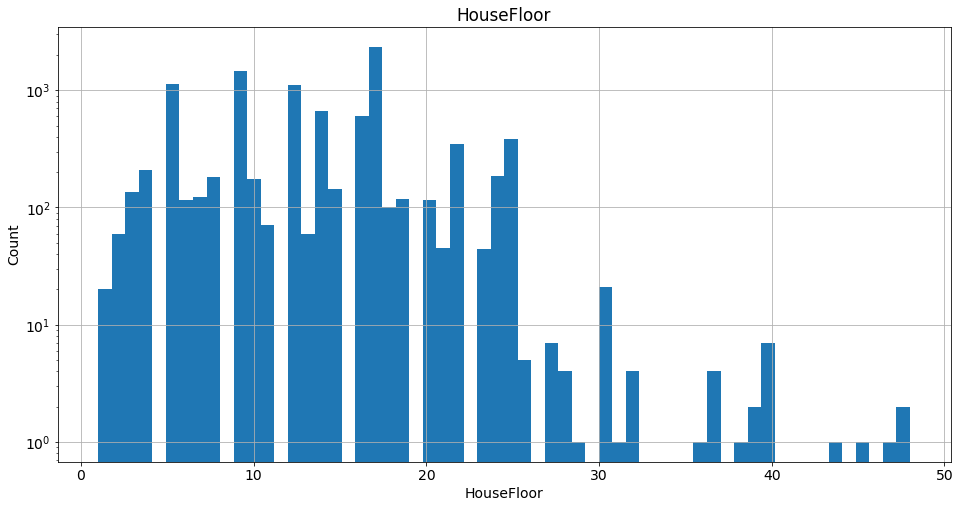

In [127]:
graph_log(train_df, 'HouseFloor', 60)

In [128]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     10000 non-null  object 
 1   DistrictId             10000 non-null  object 
 2   Rooms                  10000 non-null  float64
 3   Square                 10000 non-null  float64
 4   LifeSquare             10000 non-null  float64
 5   KitchenSquare          10000 non-null  float64
 6   Floor                  10000 non-null  float64
 7   HouseFloor             10000 non-null  float64
 8   HouseYear              10000 non-null  int64  
 9   Ecology_1              10000 non-null  float64
 10  Ecology_2              10000 non-null  object 
 11  Ecology_3              10000 non-null  object 
 12  Social_1               10000 non-null  int64  
 13  Social_2               10000 non-null  int64  
 14  Social_3               10000 non-null  int64  
 15  Hea

Смотрим критерий HouseYear

In [129]:
train_df[['HouseYear']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   HouseYear  10000 non-null  int64
dtypes: int64(1)
memory usage: 78.2 KB


In [130]:
train_df['HouseYear'].value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1947           1
1916           1
1910           1
1928           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

In [131]:
train_df['HouseYear'].value_counts(bins =5)

(-18140.102, 4011930.2]     9999
(16041990.8, 20052011.0]       1
(12031970.6, 16041990.8]       0
(8021950.4, 12031970.6]        0
(4011930.2, 8021950.4]         0
Name: HouseYear, dtype: int64

In [132]:
train_df['HouseYear'].mode()

0    1977
dtype: int64

In [133]:
train_df['HouseYear_outlier'] = 0

In [134]:
train_df.loc[train_df['HouseYear'] > 2021, 'HouseYear_outlier'] = 1

In [135]:
train_df.loc[train_df['HouseYear'] > 2021]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test,Floor_outlier,HouseFloor_outlier,HouseYear_outlier
8828,11607,147,2.0,44.791836,28.360393,5.0,4.0,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096,0,0,0,0,0,0,0,0,1
9163,10814,109,1.0,37.265070,20.239714,9.0,9.0,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396,0,0,0,0,0,0,0,0,1


In [136]:
train_df.loc[train_df['HouseYear'] == 4968, 'HouseYear'] = 1968

In [137]:
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = 2005

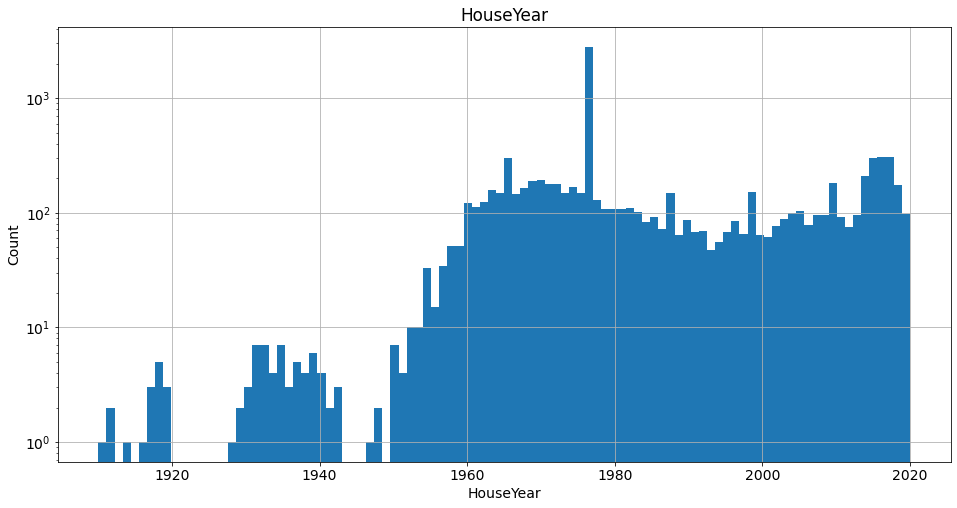

In [138]:
graph_log(train_df, 'HouseYear', 100)

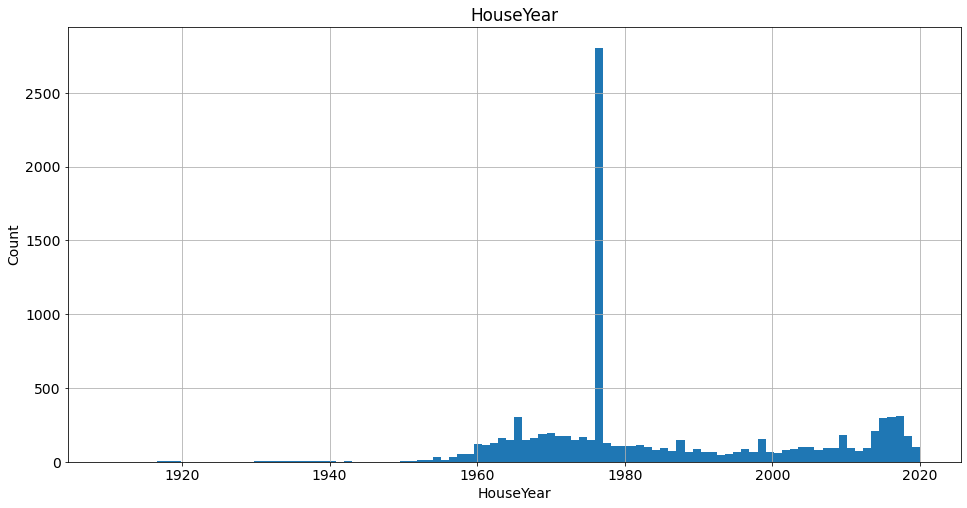

In [139]:
graph(train_df, 'HouseYear', 100)

Оставляем значение 1977, не считаем это за выброс

In [140]:
train_df['HouseYear'].value_counts(bins =5)

(1976.0, 1998.0]                4387
(1954.0, 1976.0]                2811
(1998.0, 2020.0]                2681
(1932.0, 1954.0]                  90
(1909.8890000000001, 1932.0]      31
Name: HouseYear, dtype: int64

In [141]:
train_df['HouseYear'].sort_values().unique()

array([1910, 1912, 1914, 1916, 1917, 1918, 1919, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942,
       1947, 1948, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

In [142]:
train_df[train_df['HouseYear'] == 1977]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test,Floor_outlier,HouseFloor_outlier,HouseYear_outlier
3,2352,1,1.0,40.409907,34.409907,6.0,10.0,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,0,1,0,1,0,0,0,0,0
8,9951,1,1.0,46.887892,44.628132,6.0,12.0,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732,0,1,0,0,0,0,0,0,0
18,4581,1,1.0,47.582480,41.582480,6.0,16.0,16.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,128803.593810,0,1,0,1,0,0,0,0,0
24,4717,27,1.0,44.203947,38.203947,6.0,2.0,2.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958,0,1,0,1,0,0,1,1,0
25,4521,6,2.0,65.409965,59.409965,6.0,18.0,18.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,191205.272608,0,1,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9978,4851,1,1.0,39.314342,33.314342,6.0,13.0,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,137782.941940,0,1,0,1,0,0,0,0,0
9982,10268,27,1.0,36.112393,30.112393,6.0,9.0,16.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,94881.691800,0,1,0,1,0,0,0,0,0
9983,647,1,2.0,63.324025,57.324025,6.0,4.0,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,183809.327114,0,1,0,1,0,0,0,0,0
9991,11173,6,2.0,62.648779,56.648779,6.0,6.0,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,182625.548872,0,1,0,1,0,0,0,0,0


Смотрим Ecology_1         

In [143]:
train_df[['Ecology_1']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ecology_1  10000 non-null  float64
dtypes: float64(1)
memory usage: 78.2 KB


In [144]:
train_df[['Ecology_1']].describe()

,Ecology_1
count,10000.000000
mean,0.118858
std,0.119025
min,0.000000
25%,0.017647
50%,0.075424
75%,0.195781
max,0.521867


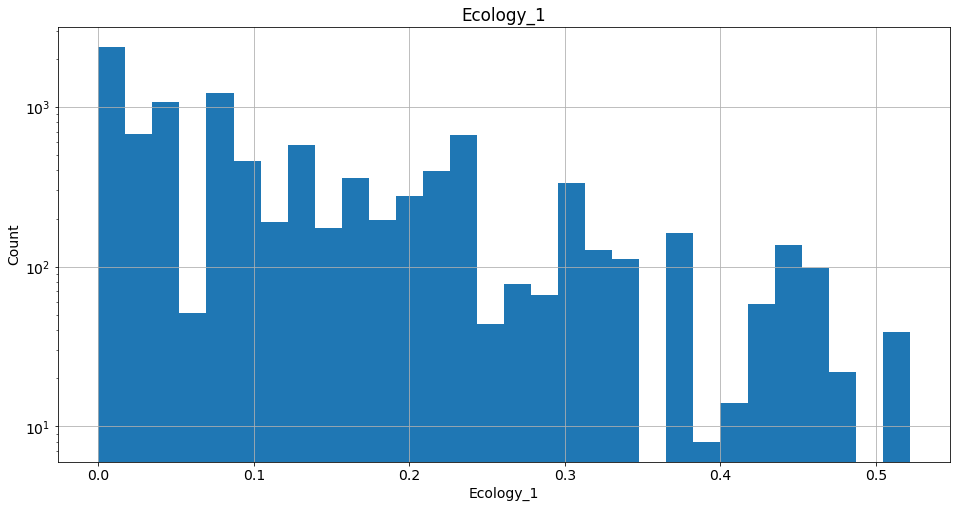

In [145]:
graph_log(train_df, 'Ecology_1', 30)

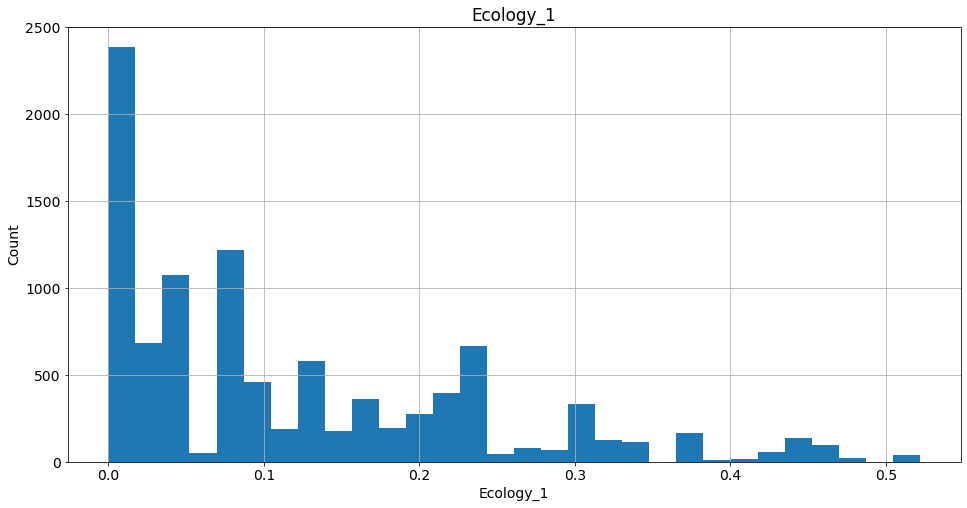

In [146]:
graph(train_df, 'Ecology_1', 30)

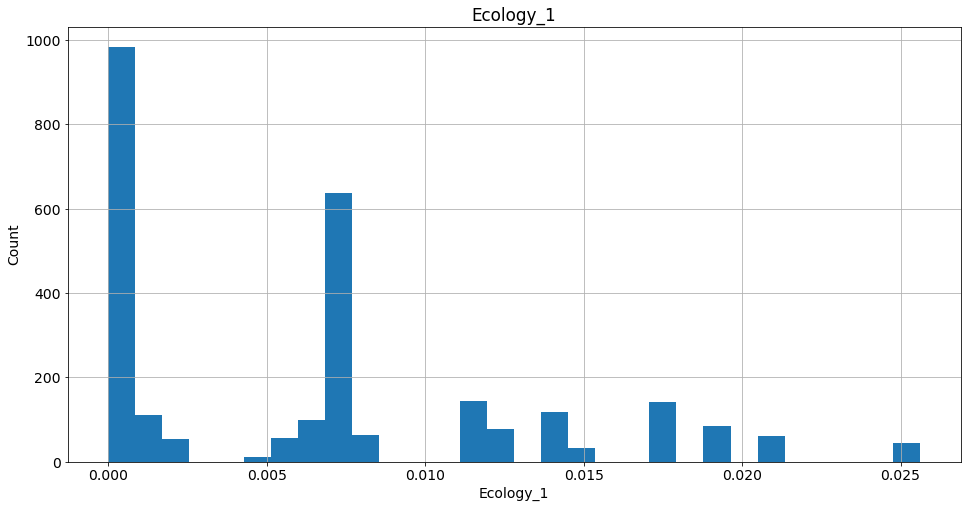

In [147]:
graph((train_df[train_df['Ecology_1'] < train_df['Ecology_1'].quantile(0.275)]), 'Ecology_1', 30)

In [148]:
train_df['Ecology_1_outlier'] = 0

In [149]:
train_df['Ecology_1'].quantile(0.975)

0.43788524

In [150]:
train_df[train_df['Ecology_1'] > train_df['Ecology_1'].quantile(0.975)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test,Floor_outlier,HouseFloor_outlier,HouseYear_outlier,Ecology_1_outlier
17,1190,8,2.0,49.396000,28.299600,5.0,5.0,5.0,1962,0.458174,B,A,26,4439,1,1130.0,1,5,B,186971.926566,0,0,0,0,0,0,1,0,0,0
177,15286,129,2.0,52.295748,27.716149,10.0,1.0,16.0,1983,0.460556,B,B,20,4386,14,NaN,1,5,B,274828.725535,0,0,0,0,0,0,0,0,0,0
189,5810,8,1.0,43.488871,19.146728,8.0,8.0,14.0,2009,0.458174,B,A,26,4439,1,1130.0,1,5,B,203558.797804,0,0,0,0,0,0,0,0,0,0
201,15045,127,1.0,35.551265,15.418166,9.0,3.0,9.0,1962,0.486246,B,B,13,2514,19,NaN,0,6,B,150063.024839,0,0,0,0,0,0,0,0,0,0
231,10190,8,2.0,52.960125,30.426607,7.0,6.0,14.0,1985,0.458174,B,A,26,4439,1,1130.0,1,5,B,211197.302549,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9567,11463,129,3.0,72.953912,39.478723,9.0,15.0,15.0,1991,0.460556,B,B,20,4386,14,NaN,1,5,B,358129.914474,0,0,0,0,0,0,1,0,0,0
9627,16070,93,1.0,38.833506,20.537814,9.0,9.0,16.0,1986,0.521867,B,B,25,6149,0,NaN,0,0,B,144421.389862,0,0,0,0,0,0,0,0,0,0
9958,1914,94,1.0,41.514367,22.579169,9.0,6.0,16.0,1977,0.521867,B,B,25,6149,0,NaN,0,0,B,148786.015208,0,0,0,0,0,0,0,0,0,0
9985,277,93,1.0,34.723984,19.840550,9.0,6.0,16.0,1988,0.521867,B,B,25,6149,0,NaN,0,0,B,149649.082219,0,0,0,0,0,0,0,0,0,0


In [151]:
# смотрим что поменять
quant = train_df['Ecology_1'].quantile(0.275)
count = train_df.loc[(train_df['Ecology_1'] < quant), 'Ecology_1'].count()
print(quant, '\n', count)

0.033493708 
 2713


In [152]:
# смотрим на что поменять
print((train_df['Ecology_1'].mode()),'\n' ,(train_df['Ecology_1'].mean()))

0    0.007122
dtype: float64 
 0.11885751885429463


In [153]:
train_df[train_df['Ecology_1'] < train_df['Ecology_1'].quantile(0.275)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test,Floor_outlier,HouseFloor_outlier,HouseYear_outlier,Ecology_1_outlier
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850,0,0,0,0,0,0,0,0,0,0
3,2352,1,1.0,40.409907,34.409907,6.0,10.0,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,0,1,0,1,0,0,0,0,0,0
5,5804,99,3.0,62.528465,47.103833,6.0,9.0,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,161044.944138,0,0,0,0,0,0,0,0,0,0
7,13072,59,2.0,50.391814,32.893256,8.0,8.0,17.0,1986,0.019509,B,B,37,7687,11,176.0,5,5,B,326174.175191,0,0,0,0,0,0,0,0,0,0
8,9951,1,1.0,46.887892,44.628132,6.0,12.0,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9978,4851,1,1.0,39.314342,33.314342,6.0,13.0,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,137782.941940,0,1,0,1,0,0,0,0,0,0
9983,647,1,2.0,63.324025,57.324025,6.0,4.0,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,183809.327114,0,1,0,1,0,0,0,0,0,0
9986,12067,2,1.0,40.488273,23.382283,7.0,2.0,4.0,1961,0.000000,B,B,33,7425,1,NaN,2,5,B,174542.979134,0,0,0,0,0,0,0,0,0,0
9987,11665,1,2.0,62.690057,52.690057,10.0,19.0,22.0,2018,0.007122,B,B,1,264,0,NaN,0,1,B,203908.192698,0,0,0,0,0,0,0,0,0,0


In [154]:
train_df[train_df['Ecology_1'] <= 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test,Floor_outlier,HouseFloor_outlier,HouseYear_outlier,Ecology_1_outlier
22,1550,7,3.0,86.326360,46.097241,10.0,3.0,17.0,1986,0.0,B,B,23,5067,4,NaN,2,6,B,421803.748753,0,0,0,0,0,0,0,0,0,0
51,12774,157,2.0,62.747509,28.196813,8.0,5.0,10.0,1956,0.0,B,B,30,7538,87,4702.0,5,5,B,555661.943969,0,0,0,0,0,0,0,0,0,0
98,7028,111,2.0,54.392900,30.792077,8.0,15.0,17.0,1990,0.0,B,B,36,6714,2,2672.0,0,2,B,214439.612368,0,0,0,0,0,0,0,0,0,0
105,9544,46,1.0,36.136757,21.140934,5.0,3.0,5.0,1968,0.0,B,B,47,11319,0,1145.0,3,5,B,173393.070968,0,0,0,0,0,0,0,0,0,0
121,16102,17,1.0,38.595782,19.418504,10.0,12.0,12.0,1966,0.0,B,B,18,3374,5,620.0,1,2,B,202533.970644,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9892,15232,18,3.0,66.047513,46.353477,6.0,12.0,12.0,1977,0.0,B,B,30,5562,0,NaN,0,5,A,219998.530312,0,0,0,0,0,0,0,0,0,0
9905,12872,17,3.0,57.818706,39.994598,5.0,5.0,5.0,1962,0.0,B,B,18,3374,5,620.0,1,2,B,276683.071344,0,0,0,0,0,0,0,0,0,0
9961,7931,181,1.0,34.911269,18.433155,6.0,10.0,12.0,1955,0.0,B,B,8,1423,37,562.0,1,8,B,397528.736061,0,0,0,0,0,0,0,0,0,0
9974,4199,17,2.0,38.676356,22.427115,6.0,2.0,9.0,1967,0.0,B,B,18,3374,5,620.0,1,2,B,183948.005251,0,0,0,0,0,0,0,0,0,0


In [155]:
train_df.loc[(train_df['Ecology_1'] == 0), 'Ecology_1'].count()

537

In [156]:
train_df['Ecology_1'].value_counts()

0.007122    587
0.000000    537
0.243205    511
0.072158    486
0.075779    346
           ... 
0.386772      6
0.011320      3
0.394094      2
0.012522      1
0.014334      1
Name: Ecology_1, Length: 129, dtype: int64

In [157]:
train_df['Ecology_1'].sort_values().unique()

array([0.00000000e+00, 1.80000000e-09, 6.99893000e-05, 7.81528000e-05,
       1.69676000e-04, 6.99119000e-04, 9.91363000e-04, 9.95363000e-04,
       2.21166500e-03, 4.94935800e-03, 5.76745100e-03, 6.07615200e-03,
       7.12231700e-03, 7.65851500e-03, 7.72028200e-03, 1.13198100e-02,
       1.16541270e-02, 1.23388860e-02, 1.25216340e-02, 1.40579200e-02,
       1.40729610e-02, 1.43339470e-02, 1.44231140e-02, 1.45807160e-02,
       1.50168920e-02, 1.76470530e-02, 1.95087960e-02, 2.07413260e-02,
       2.56091570e-02, 3.34937080e-02, 3.43314970e-02, 3.46560820e-02,
       3.51452670e-02, 3.61222920e-02, 3.62700890e-02, 3.71778180e-02,
       3.73164520e-02, 3.86929870e-02, 4.02427640e-02, 4.11163540e-02,
       4.11246340e-02, 4.13654460e-02, 4.20315870e-02, 4.23072710e-02,
       4.96372570e-02, 4.98633870e-02, 5.02720140e-02, 5.07555690e-02,
       5.09000580e-02, 5.18154350e-02, 5.19420620e-02, 6.07530490e-02,
       6.96603440e-02, 6.97533610e-02, 7.21575810e-02, 7.54236800e-02,
      

In [158]:
train_df['Ecology_1_q'] = train_df['Ecology_1'] # создадим дублирующий столбец

In [159]:
train_df['Ecology_1_q_outlier'] = 0

In [160]:
train_df.loc[(train_df['Ecology_1_q'] < train_df['Ecology_1_q'].quantile(0.275)), 'Ecology_1_q_outlier'] = 1
train_df.loc[(train_df['Ecology_1_q'] < train_df['Ecology_1_q'].quantile(0.275)), 'Ecology_1_q'] = (train_df['Ecology_1'].mean())


In [161]:
train_df.loc[(train_df['Ecology_1_q'] > train_df['Ecology_1_q'].quantile(0.975)), 'Ecology_1_q_outlier'] = 1
train_df.loc[(train_df['Ecology_1_q'] > train_df['Ecology_1_q'].quantile(0.975)), 'Ecology_1_q'] = (train_df['Ecology_1'].mean())

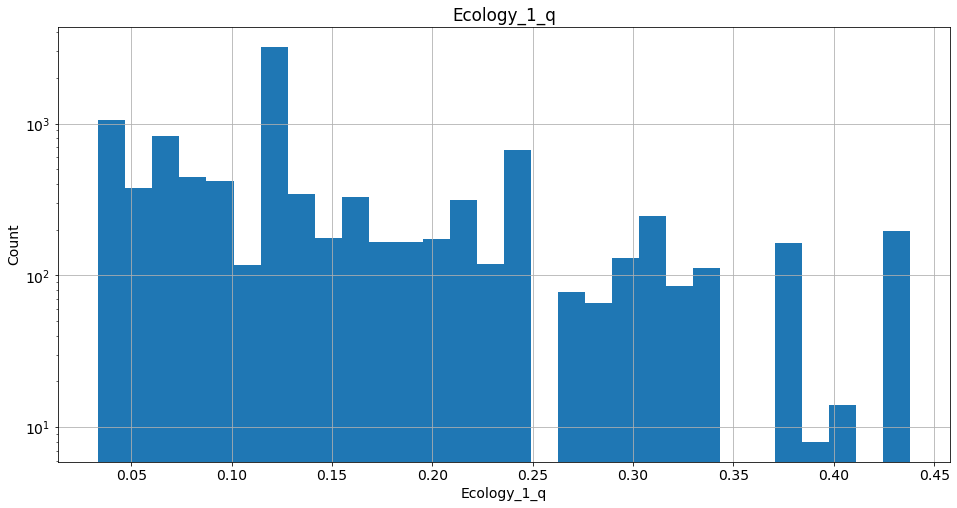

In [162]:
graph_log(train_df, 'Ecology_1_q', 30)

In [163]:
# Сохраняем результат
train_df.to_csv('./train_save.csv', index=False, encoding='utf-8', sep=';')


Смотрим Ecology_2

In [164]:
train_df[['Ecology_2']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Ecology_2  10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB


In [165]:
train_df['Ecology_2'].unique()

array(['B', 'A'], dtype=object)

In [166]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [167]:
pd.get_dummies(train_df['Ecology_2'])

,A,B
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
9995,0,1
9996,0,1
9997,0,1
9998,0,1


In [168]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_2'])], axis=1)

In [169]:
train_df.rename(columns={'A': 'Ecology_2_A'}, inplace=True)

In [170]:
train_df.rename(columns={'B': 'Ecology_2_B'}, inplace=True)

In [171]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test,Floor_outlier,HouseFloor_outlier,HouseYear_outlier,Ecology_1_outlier,Ecology_1_q,Ecology_1_q_outlier,Ecology_2_A,Ecology_2_B
0,11809,27,3.0,115.027311,105.027311,10.0,4.0,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,0,0,0,1,0,0,0,0,0,0,0.075424,0,0,1
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407,0,0,0,0,0,0,0,0,0,0,0.118537,0,0,1
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850,0,0,0,0,0,0,0,0,0,0,0.118858,1,0,1
3,2352,1,1.0,40.409907,34.409907,6.0,10.0,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,0,1,0,1,0,0,0,0,0,0,0.118858,1,0,1
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,0,0,0,0,0,0,0,0,0,0,0.282798,0,0,1


Смортим Ecology_3

In [172]:
train_df[['Ecology_3']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Ecology_3  10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB


In [173]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [174]:
Eco_3 = {'A': 0, 'B': 1}
train_df['Ecology_3_01'] = train_df['Ecology_3'].map(Eco_3)

In [175]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test,Floor_outlier,HouseFloor_outlier,HouseYear_outlier,Ecology_1_outlier,Ecology_1_q,Ecology_1_q_outlier,Ecology_2_A,Ecology_2_B,Ecology_3_01
0,11809,27,3.0,115.027311,105.027311,10.0,4.0,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,0,0,0,1,0,0,0,0,0,0,0.075424,0,0,1,1
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407,0,0,0,0,0,0,0,0,0,0,0.118537,0,0,1,1
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850,0,0,0,0,0,0,0,0,0,0,0.118858,1,0,1,1
3,2352,1,1.0,40.409907,34.409907,6.0,10.0,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,0,1,0,1,0,0,0,0,0,0,0.118858,1,0,1,1
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,0,0,0,0,0,0,0,0,0,0,0.282798,0,0,1,1


Смотрим признак Social_1

In [176]:
train_df[['Social_1']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Social_1  10000 non-null  int64
dtypes: int64(1)
memory usage: 78.2 KB


In [177]:
train_df[['Social_1']].describe()

,Social_1
count,10000.000000
mean,24.687000
std,17.532614
min,0.000000
25%,6.000000
50%,25.000000
75%,36.000000
max,74.000000


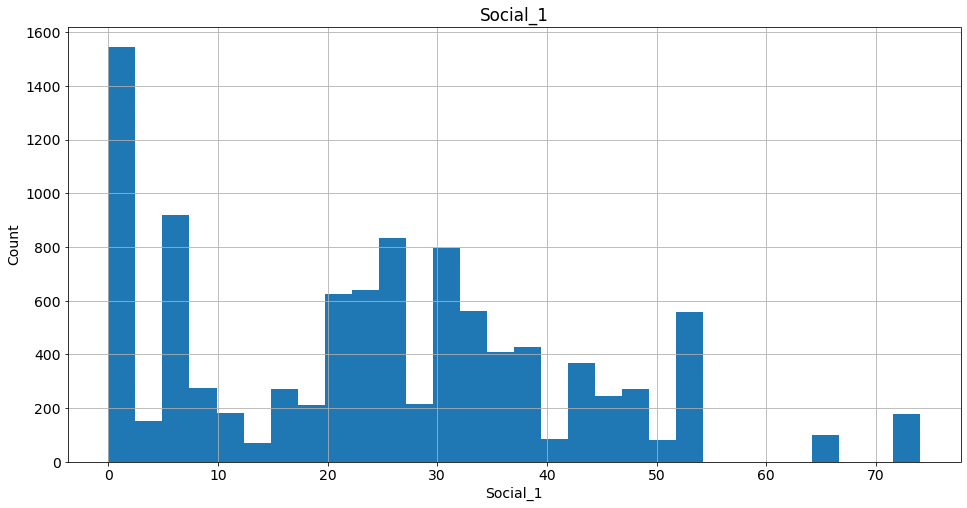

In [178]:
graph(train_df, 'Social_1', 30)

In [179]:
train_df['Social_1'].quantile(0.975)

66.0

In [180]:
train_df['Social_1'].quantile(0.025)

1.0

In [181]:
train_df['Social_1'].mean()

24.687

In [182]:
train_df['Social_1_q'] = train_df['Social_1']
train_df['Social_1_q_outlier'] = 0

In [183]:
train_df.loc[(train_df['Social_1_q'] < train_df['Social_1'].quantile(0.025))]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test,Floor_outlier,HouseFloor_outlier,HouseYear_outlier,Ecology_1_outlier,Ecology_1_q,Ecology_1_q_outlier,Ecology_2_A,Ecology_2_B,Ecology_3_01,Social_1_q,Social_1_q_outlier
38,7679,23,2.0,55.521797,49.521797,6.0,3.0,4.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,93217.752924,0,1,0,1,0,0,0,0,0,0,0.034656,0,0,1,1,0,0
74,9393,23,1.0,37.365229,31.365229,6.0,3.0,3.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,91945.045702,0,1,0,1,0,0,0,0,0,0,0.034656,0,0,1,1,0,0
94,12339,23,1.0,47.485585,41.485585,6.0,5.0,5.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,126602.673982,0,1,0,1,0,0,1,1,0,0,0.034656,0,0,1,1,0,0
130,8800,23,1.0,29.706031,23.706031,6.0,5.0,12.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,60502.583500,0,1,0,1,0,0,0,0,0,0,0.034656,0,0,1,1,0,0
234,4935,23,1.0,28.859885,22.859885,6.0,11.0,11.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,68375.615508,0,1,0,1,0,0,1,0,0,0,0.034656,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9614,1334,23,1.0,29.401008,23.401008,6.0,4.0,17.0,2019,0.034656,B,B,0,168,0,NaN,0,0,B,71690.969474,0,1,0,1,0,0,0,0,0,0,0.034656,0,0,1,1,0,0
9665,3471,23,1.0,46.691679,40.691679,6.0,15.0,15.0,2016,0.034656,B,B,0,168,0,NaN,0,0,B,143131.236196,0,1,0,1,0,0,1,0,0,0,0.034656,0,0,1,1,0,0
9735,14841,23,2.0,59.854374,58.352188,6.0,2.0,17.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,100938.326985,0,1,0,0,0,0,0,0,0,0,0.034656,0,0,1,1,0,0
9873,15219,23,1.0,34.632986,28.632986,6.0,4.0,4.0,2015,0.034656,B,B,0,168,0,NaN,0,0,B,87806.957199,0,1,0,0,0,0,1,1,0,0,0.034656,0,0,1,1,0,0


In [184]:
train_df.loc[(train_df['Social_1_q'] < train_df['Social_1'].quantile(0.025)), 'Social_1_q_outlier'] = 1 

In [185]:
train_df.loc[(train_df['Social_1_q'] < train_df['Social_1'].quantile(0.025)), 'Social_1_q'] = train_df['Social_1'].mean() 

In [186]:
train_df.loc[(train_df['Social_1_q'] > train_df['Social_1'].quantile(0.975)), 'Social_1_q_outlier'] = 1 

In [187]:
train_df.loc[(train_df['Social_1_q'] > train_df['Social_1'].quantile(0.925)), 'Social_1_q'] = train_df['Social_1'].mean() 

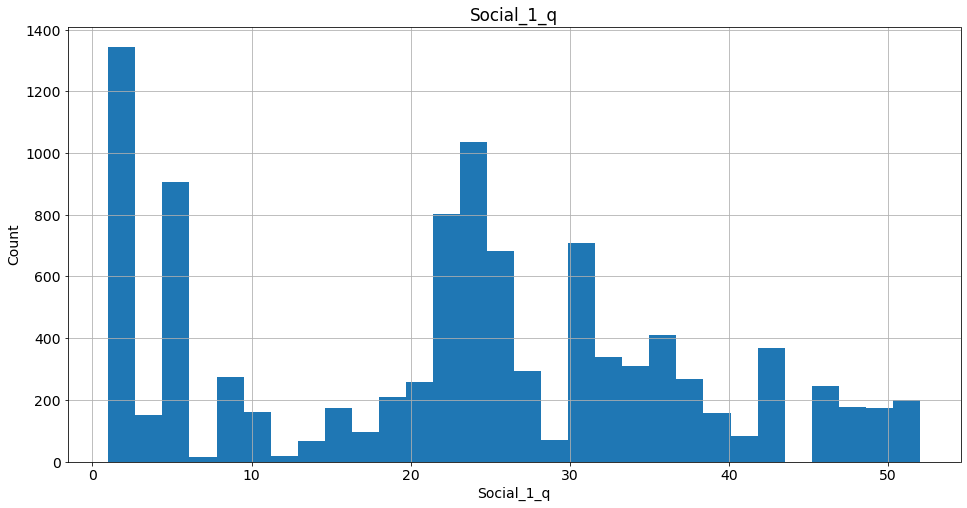

In [188]:
graph(train_df, 'Social_1_q', 30)

In [189]:
train_df['Social_1'].value_counts()

2     688
1     654
25    557
5     528
30    465
23    434
6     377
22    367
53    355
34    311
33    252
46    245
31    243
43    238
9     213
36    209
21    207
37    205
24    205
52    201
0     201
35    200
47    177
74    176
39    159
27    151
28    144
4     141
11    138
42    129
26    127
16    123
19    118
66     99
17     96
49     95
18     92
32     87
41     83
50     79
29     70
38     64
8      62
15     51
20     50
14     46
10     24
13     22
12     18
7      15
3       9
Name: Social_1, dtype: int64

Смотрим признак Social_2

In [190]:
train_df['Social_2'].value_counts()

264     587
1564    511
629     486
1437    346
6398    245
       ... 
568       3
1423      3
662       2
507       1
528       1
Name: Social_2, Length: 142, dtype: int64

In [191]:
train_df[['Social_2']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Social_2  10000 non-null  int64
dtypes: int64(1)
memory usage: 78.2 KB


In [192]:
train_df[['Social_2']].describe()

,Social_2
count,10000.000000
mean,5352.157400
std,4006.799803
min,168.000000
25%,1564.000000
50%,5285.000000
75%,7227.000000
max,19083.000000


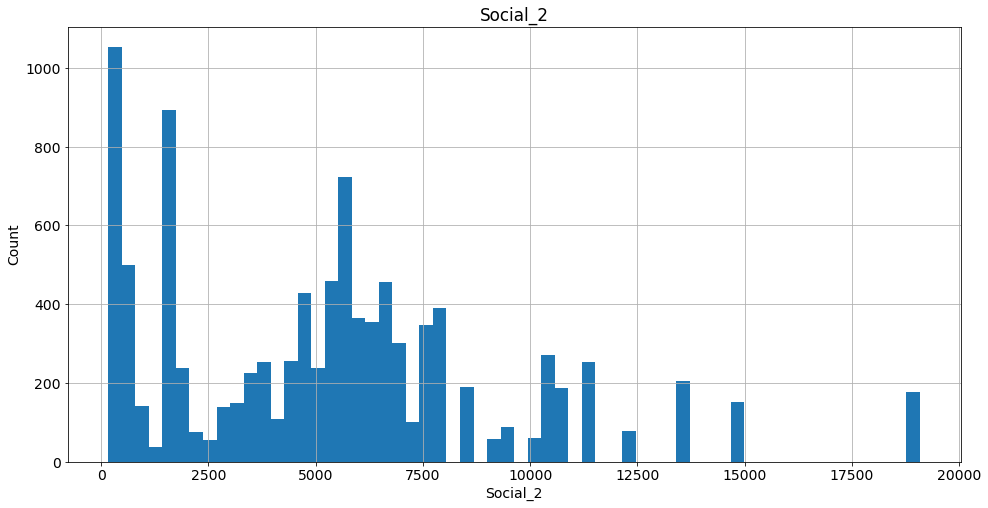

In [193]:
graph(train_df, 'Social_2', 60)

In [194]:
train_df['Social_2'].quantile(0.975)

14892.0

In [195]:
train_df['Social_2'].quantile(0.025)

264.0

In [196]:
train_df['Social_2'].mean()

5352.1574

In [197]:
train_df['Social_2'].mode()

0    264
dtype: int64

In [198]:
train_df['Social_2_q'] = train_df['Social_2']
train_df['Social_2_q_outlier'] = 0

In [199]:
train_df.loc[(train_df['Social_2_q'] < train_df['Social_2'].quantile(0.025))][['Social_1','Social_2']]

,Social_1,Social_2
38,0,168
74,0,168
94,0,168
130,0,168
234,0,168
...,...,...
9614,0,168
9665,0,168
9735,0,168
9873,0,168


In [200]:
train_df.loc[(train_df['Social_2_q'] < train_df['Social_2'].quantile(0.025)), 'Social_2_q_outlier'] = 1 

In [201]:
train_df.loc[(train_df['Social_2_q'] < train_df['Social_2'].quantile(0.025)), 'Social_2_q'] = train_df['Social_2'].mean() 

In [202]:
train_df.loc[(train_df['Social_2_q'] > train_df['Social_2'].quantile(0.975)), 'Social_2_q_outlier'] = 1 

In [203]:
train_df.loc[(train_df['Social_2_q'] > train_df['Social_2'].quantile(0.925)), 'Social_2_q'] = train_df['Social_2'].mean() 

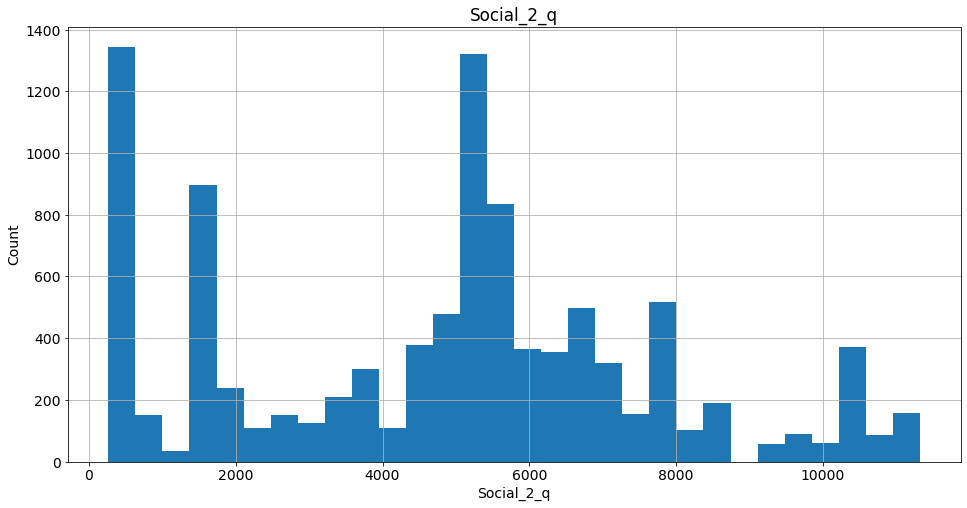

In [204]:
graph(train_df, 'Social_2_q', 30)

In [205]:
train_df['Social_2'].value_counts()

264     587
1564    511
629     486
1437    346
6398    245
       ... 
568       3
1423      3
662       2
507       1
528       1
Name: Social_2, Length: 142, dtype: int64

Смотрим признак Social_3

In [206]:
train_df[['Social_3']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Social_3  10000 non-null  int64
dtypes: int64(1)
memory usage: 78.2 KB


In [207]:
train_df[['Social_3']].describe()

,Social_3
count,10000.000000
mean,8.039200
std,23.831875
min,0.000000
25%,0.000000
50%,2.000000
75%,5.000000
max,141.000000


In [208]:
train_df['Social_3'].value_counts()

0      2997
1      1861
3      1136
4       835
2       635
6       423
5       391
141     245
9       192
7       184
11      172
8       170
10      142
16      101
14       97
27       59
48       58
56       49
84       43
24       37
87       27
59       25
93       25
19       22
20       19
23       18
39       15
73       10
45        9
37        3
Name: Social_3, dtype: int64

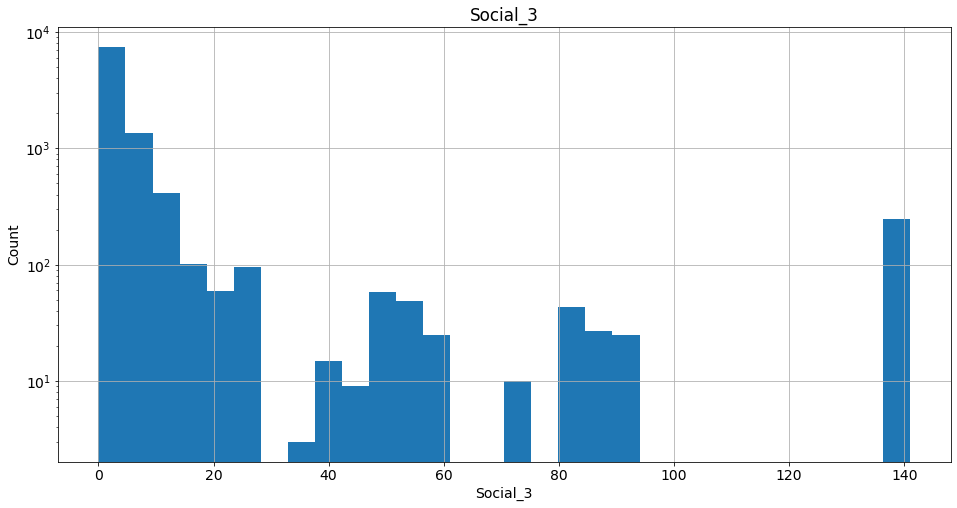

In [209]:
graph_log(train_df, 'Social_3', 30)

In [210]:
train_df['Social_3'].quantile(0.975)

93.0

In [211]:
train_df['Social_3'].quantile(0.025)

0.0

In [212]:
train_df['Social_3'].mean()

8.0392

In [213]:
train_df['Social_3_q'] = train_df['Social_3']
train_df['Social_3_q_outlier'] = 0

In [214]:
train_df.loc[(train_df['Social_3_q'] < train_df['Social_3'].quantile(0.025))]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test,Floor_outlier,HouseFloor_outlier,HouseYear_outlier,Ecology_1_outlier,Ecology_1_q,Ecology_1_q_outlier,Ecology_2_A,Ecology_2_B,Ecology_3_01,Social_1_q,Social_1_q_outlier,Social_2_q,Social_2_q_outlier,Social_3_q,Social_3_q_outlier


In [215]:
train_df.loc[(train_df['Social_3_q'] > train_df['Social_3'].quantile(0.975))]['Social_3_q'].value_counts()

141    245
Name: Social_3_q, dtype: int64

In [216]:
train_df.loc[(train_df['Social_3_q'] > train_df['Social_3'].quantile(0.975)), 'Social_3_q_outlier'] = 1 

In [217]:
train_df.loc[(train_df['Social_3_q'] > train_df['Social_3'].quantile(0.975)), 'Social_3_q'] = train_df['Social_3'].mean() 

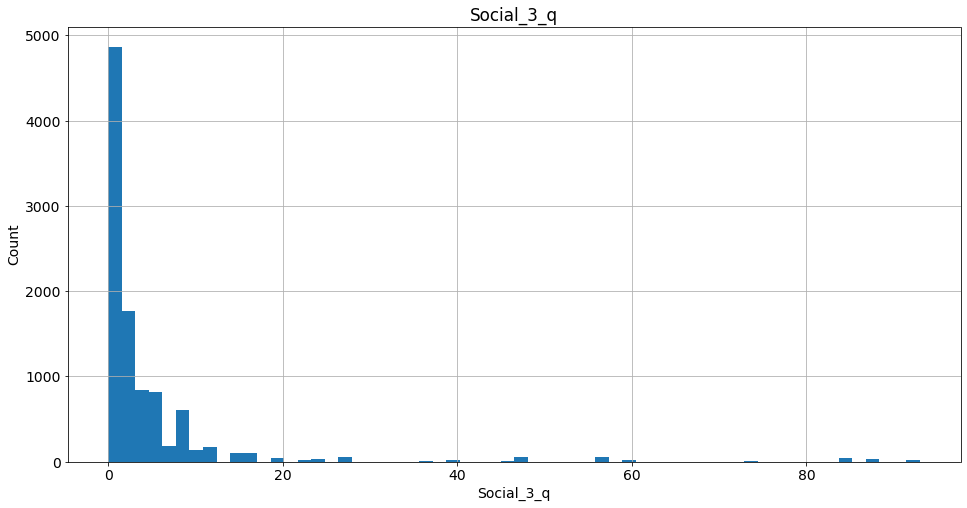

In [218]:
graph(train_df, 'Social_3_q', 60)

Смотрим признак Healthcare_1

In [219]:
train_df[['Healthcare_1']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Healthcare_1  5202 non-null   float64
dtypes: float64(1)
memory usage: 78.2 KB


In [220]:
train_df['Healthcare_1'].value_counts(bins = 5)

(-4.8500000000000005, 969.8]    2631
(969.8, 1939.6]                 1538
(1939.6, 2909.4]                 778
(3879.2, 4849.0]                 170
(2909.4, 3879.2]                  85
Name: Healthcare_1, dtype: int64

In [221]:
train_df['Healthcare_1'].describe()

count    5202.000000
mean     1142.904460
std      1021.517264
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

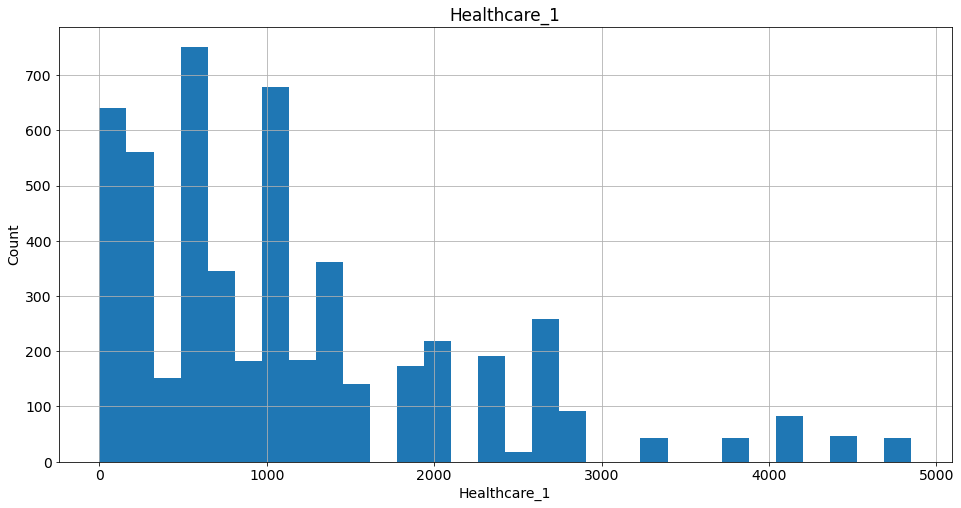

In [222]:
graph(train_df, 'Healthcare_1', 30)

In [223]:
train_df['Healthcare_1'].quantile(0.975)

4087.0

In [224]:
train_df['Healthcare_1'].quantile(0.025)

30.0

In [225]:
train_df['Healthcare_1'].mean()

1142.9044598231449

In [226]:
train_df['Healthcare_1_q'] = train_df['Healthcare_1']
train_df['Healthcare_1_q_outlier'] = 0

In [227]:
train_df.loc[(train_df['Healthcare_1_q'] <= train_df['Healthcare_1'].quantile(0.025))]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,test,Floor_outlier,HouseFloor_outlier,HouseYear_outlier,Ecology_1_outlier,Ecology_1_q,Ecology_1_q_outlier,Ecology_2_A,Ecology_2_B,Ecology_3_01,Social_1_q,Social_1_q_outlier,Social_2_q,Social_2_q_outlier,Social_3_q,Social_3_q_outlier,Healthcare_1_q,Healthcare_1_q_outlier
12,898,93,1.0,47.564443,23.574423,13.0,9.0,24.0,2012,0.050900,B,B,43,10621,1,30.0,2,3,B,199556.865905,0,0,0,0,0,0,0,0,0,0,0.050900,0,0,1,1,43.0,0,10621.0,0,1.0,0,30.0,0
37,1699,9,1.0,78.936164,76.746654,6.0,7.0,7.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,226206.962435,0,1,0,0,0,0,1,0,0,0,0.161532,0,0,1,1,25.0,0,5648.0,0,1.0,0,30.0,0
72,5643,9,1.0,36.470086,20.802645,9.0,5.0,12.0,2008,0.161532,B,B,25,5648,1,30.0,2,4,B,144224.820734,0,0,0,0,0,0,0,0,0,0,0.161532,0,0,1,1,25.0,0,5648.0,0,1.0,0,30.0,0
135,9509,9,2.0,60.900178,57.196914,6.0,2.0,11.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,166221.470210,0,1,0,0,0,0,0,0,0,0,0.161532,0,0,1,1,25.0,0,5648.0,0,1.0,0,30.0,0
157,7682,9,3.0,79.830439,48.265030,10.0,5.0,14.0,1993,0.161532,B,B,25,5648,1,30.0,2,4,B,246800.155313,0,0,0,0,0,0,0,0,0,0,0.161532,0,0,1,1,25.0,0,5648.0,0,1.0,0,30.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9870,1178,9,3.0,82.247909,80.049163,6.0,9.0,9.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,236541.355539,0,1,0,0,0,0,1,1,0,0,0.161532,0,0,1,1,25.0,0,5648.0,0,1.0,0,30.0,0
9884,5598,3,3.0,75.447455,48.360111,10.0,17.0,17.0,1986,0.050900,B,B,43,10621,1,30.0,2,3,B,262573.388970,0,0,0,0,0,0,0,0,0,0,0.050900,0,0,1,1,43.0,0,10621.0,0,1.0,0,30.0,0
9980,11084,9,1.0,40.446191,22.697171,9.0,6.0,16.0,1988,0.161532,B,B,25,5648,1,30.0,2,4,B,150826.003824,0,0,0,0,0,0,0,0,0,0,0.161532,0,0,1,1,25.0,0,5648.0,0,1.0,0,30.0,0
9988,1621,9,1.0,39.630082,22.006139,8.0,8.0,14.0,1990,0.161532,B,B,25,5648,1,30.0,2,4,B,127641.213065,0,0,0,0,0,0,0,0,0,0,0.161532,0,0,1,1,25.0,0,5648.0,0,1.0,0,30.0,0


In [228]:
train_df[(train_df['Healthcare_1_q'] < 35)]['Healthcare_1_q'].value_counts()

30.0    348
32.0     12
0.0       1
Name: Healthcare_1_q, dtype: int64

In [229]:
train_df.loc[(train_df['Healthcare_1_q'] < train_df['Healthcare_1'].quantile(0.025)), 'Healthcare_1_q_outlier'] = 1

In [230]:
train_df.loc[(train_df['Healthcare_1_q'] < train_df['Healthcare_1'].quantile(0.025)), 'Healthcare_1_q'] = train_df['Healthcare_1'].mean()

In [231]:
train_df[(train_df['Healthcare_1_q'] > train_df['Healthcare_1'].quantile(0.975))]['Healthcare_1_q'].value_counts()

4508.0    46
4129.0    37
4702.0    27
4849.0    15
Name: Healthcare_1_q, dtype: int64

In [232]:
train_df.loc[(train_df['Healthcare_1_q'] > train_df['Healthcare_1'].quantile(0.975)), 'Healthcare_1_q_outlier'] = 1

In [233]:
train_df.loc[(train_df['Healthcare_1_q'] > train_df['Healthcare_1'].quantile(0.975)), 'Healthcare_1_q'] = train_df['Healthcare_1'].mean()

In [234]:
train_df[pd.isnull(train_df['Healthcare_1_q'])]['Healthcare_1_q']

0      NaN
3      NaN
4      NaN
8      NaN
11     NaN
        ..
9993   NaN
9995   NaN
9996   NaN
9997   NaN
9999   NaN
Name: Healthcare_1_q, Length: 4798, dtype: float64

In [235]:
train_df.loc[pd.isnull(train_df['Healthcare_1_q']),'Healthcare_1_q_outlier'] = 1

In [236]:
train_df.loc[pd.isnull(train_df['Healthcare_1_q']),'Healthcare_1_q'] = train_df['Healthcare_1'].mean()

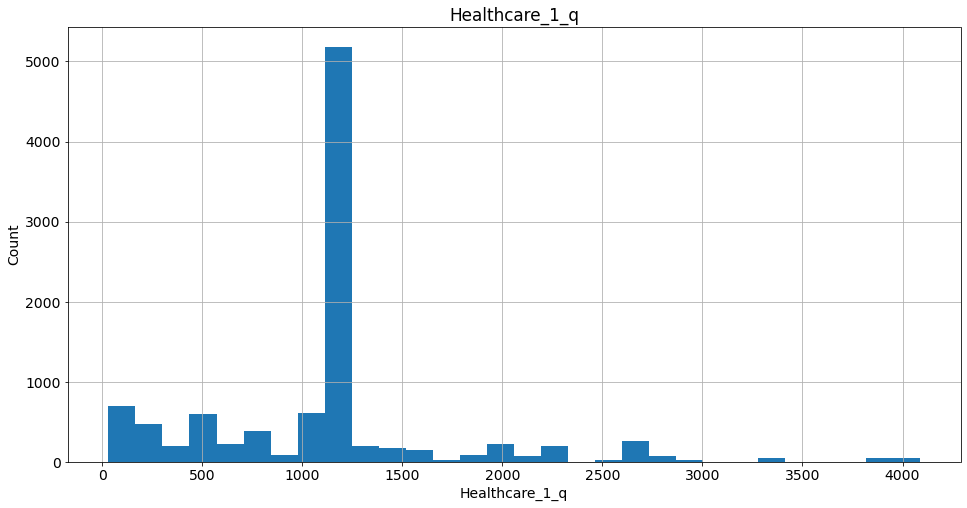

In [237]:
graph(train_df, 'Healthcare_1_q', 30)

Смотрим признак 'Helthcare_2'

In [238]:
train_df[['Helthcare_2']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Helthcare_2  10000 non-null  int64
dtypes: int64(1)
memory usage: 78.2 KB


In [239]:
train_df[['Helthcare_2']].describe()

,Helthcare_2
count,10000.000000
mean,1.319500
std,1.493601
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,6.000000


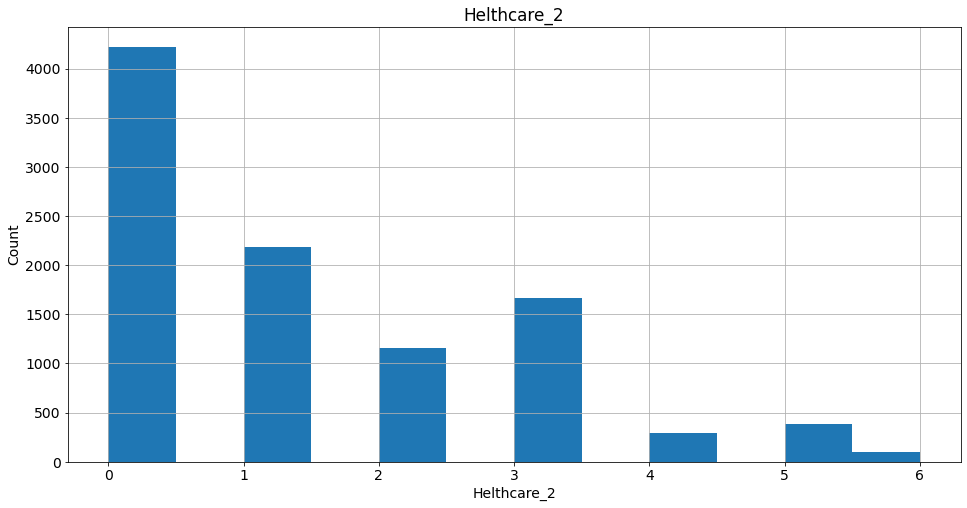

In [240]:
graph(train_df, 'Helthcare_2', 12)

In [241]:
train_df['Helthcare_2'].value_counts()

0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: Helthcare_2, dtype: int64

Признак 'Helthcare_2' оставляем без изменений. Выбросов и пропусков нет.

Смотрим признак 'Shops_1'

In [242]:
train_df[['Shops_1']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Shops_1  10000 non-null  int64
dtypes: int64(1)
memory usage: 78.2 KB


In [243]:
train_df[['Shops_1']].describe()

,Shops_1
count,10000.000000
mean,4.231300
std,4.806341
min,0.000000
25%,1.000000
50%,3.000000
75%,6.000000
max,23.000000


In [244]:
train_df['Shops_1'].value_counts()

0     2316
1     1325
5     1324
2      964
4      841
3      711
6      487
11     401
9      316
7      294
8      253
23     245
10     215
15     176
16      83
19      49
Name: Shops_1, dtype: int64

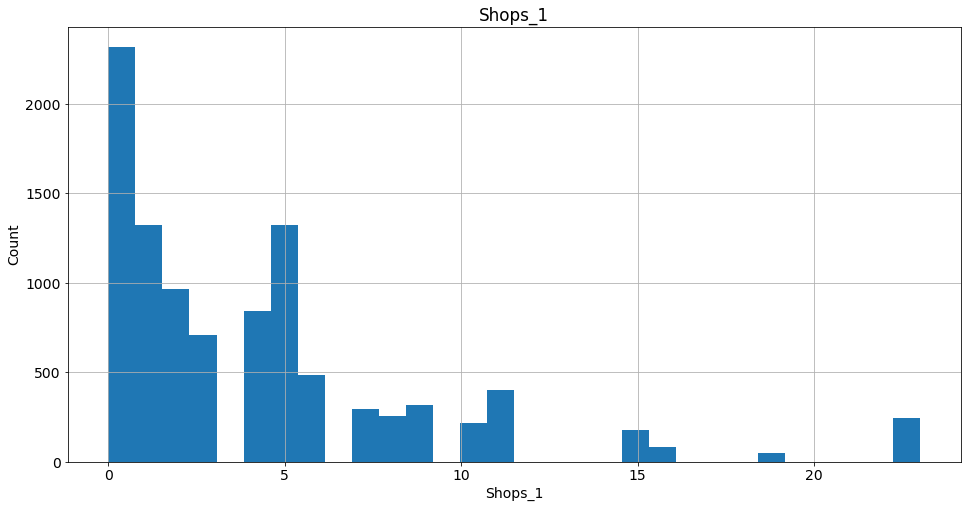

In [245]:
graph(train_df, 'Shops_1', 30)

In [246]:
train_df['Shops_1'].quantile(0.975)

19.0

In [247]:
train_df[(train_df['Shops_1'] > train_df['Shops_1'].quantile(0.975))]['Shops_1'].count()

245

In [248]:
train_df['Shops_1'].quantile(0.025)

0.0

In [249]:
round(train_df['Shops_1'].mean())

4

In [250]:
train_df['Shops_1_q'] = train_df['Shops_1']
train_df['Shops_1_q_outlier'] = 0

In [251]:
train_df.loc[(train_df['Shops_1_q'] > train_df['Shops_1_q'].quantile(0.975)), 'Shops_1_q_outlier'] = 1 

In [252]:
train_df.loc[(train_df['Shops_1_q'] > train_df['Shops_1_q'].quantile(0.975)), 'Shops_1_q'] = round(train_df['Shops_1'].mean()) 

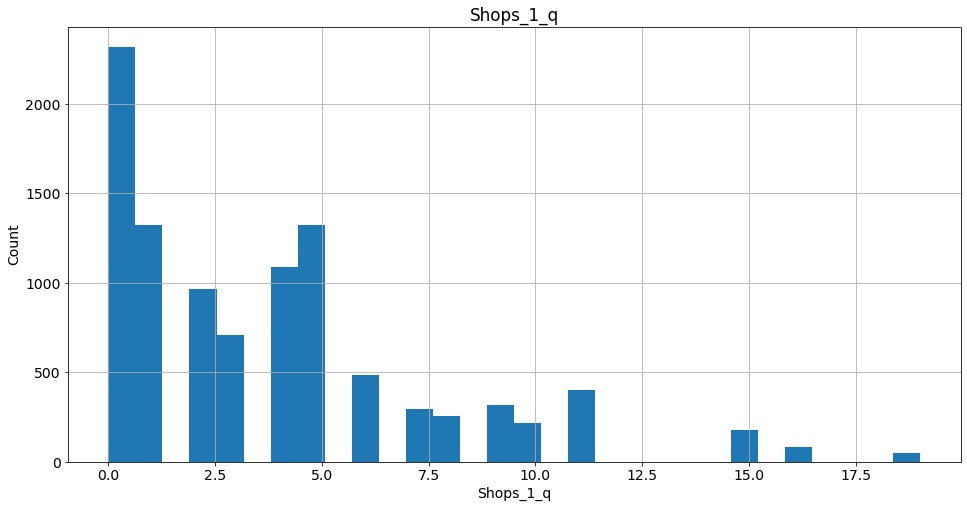

In [253]:
graph(train_df, 'Shops_1_q', 30)

Смотрим признак Shops

In [254]:
train_df[['Shops_2']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Shops_2  10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB


In [255]:
train_df[['Shops_2']].describe()

,Shops_2
count,10000
unique,2
top,B
freq,9175


In [256]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

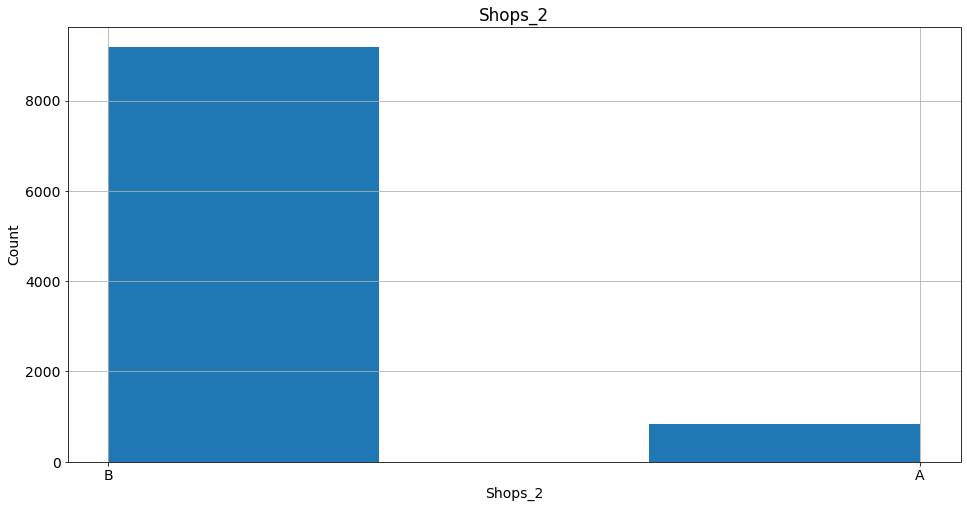

In [257]:
graph(train_df, 'Shops_2', 3)

In [258]:
Sh_2 = {'A': 0, 'B': 1}

In [259]:
train_df['Shops_2_01'] = train_df['Shops_2'].map(Sh_2)

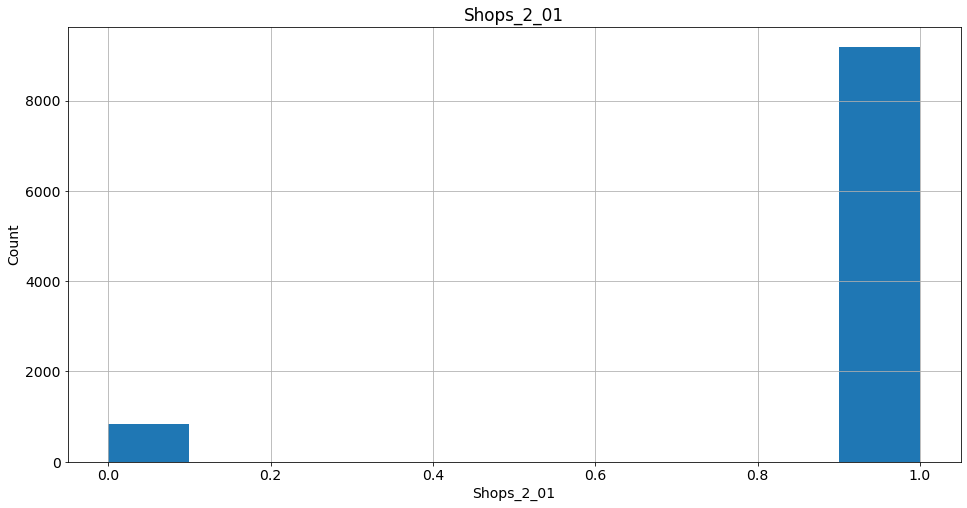

In [260]:
graph(train_df, 'Shops_2_01', 10)

In [261]:
train_df.drop(columns = 'test', inplace = True)

In [262]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      10000 non-null  object 
 1   DistrictId              10000 non-null  object 
 2   Rooms                   10000 non-null  float64
 3   Square                  10000 non-null  float64
 4   LifeSquare              10000 non-null  float64
 5   KitchenSquare           10000 non-null  float64
 6   Floor                   10000 non-null  float64
 7   HouseFloor              10000 non-null  float64
 8   HouseYear               10000 non-null  int64  
 9   Ecology_1               10000 non-null  float64
 10  Ecology_2               10000 non-null  object 
 11  Ecology_3               10000 non-null  object 
 12  Social_1                10000 non-null  int64  
 13  Social_2                10000 non-null  int64  
 14  Social_3                10000 non-null 

### Генерация новых признаков###

In [263]:
# train_df.loc[(train_df['DistrictId'] == 9)]

In [264]:
# train_df['DistrictId']

In [265]:
# train_df['DistrictId'].value_counts()

In [266]:
# train_df.loc[(train_df['DistrictId'].value_counts() == 2)]

In [267]:
district_size = train_df['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [268]:
district_size.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DistrictId    205 non-null    object
 1   DistrictSize  205 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.3+ KB


In [269]:
train_df[['DistrictId']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DistrictId  10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB


In [270]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,Floor_outlier,HouseFloor_outlier,HouseYear_outlier,Ecology_1_outlier,Ecology_1_q,Ecology_1_q_outlier,Ecology_2_A,Ecology_2_B,Ecology_3_01,Social_1_q,Social_1_q_outlier,Social_2_q,Social_2_q_outlier,Social_3_q,Social_3_q_outlier,Healthcare_1_q,Healthcare_1_q_outlier,Shops_1_q,Shops_1_q_outlier,Shops_2_01,DistrictSize
0,11809,27,3.0,115.027311,105.027311,10.0,4.0,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,0,0,0,1,0,0,0,0,0,0.075424,0,0,1,1,11.0,0,3097.0,0,0.0,0,1142.90446,1,0,0,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407,0,0,0,0,0,0,0,0,0,0.118537,0,0,1,1,30.0,0,6207.0,0,1.0,0,1183.00000,0,0,0,1,78
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850,0,0,0,0,0,0,0,0,0,0.118858,1,0,1,1,33.0,0,5261.0,0,0.0,0,240.00000,0,1,0,1,652
3,2352,1,1.0,40.409907,34.409907,6.0,10.0,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,0,1,0,1,0,0,0,0,0,0.118858,1,0,1,1,1.0,0,264.0,0,0.0,0,1142.90446,1,1,0,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,0,0,0,0,0,0,0,0,0,0.282798,0,0,1,1,33.0,0,8667.0,0,2.0,0,1142.90446,1,6,0,1,89


In [271]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [272]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,Floor_outlier,HouseFloor_outlier,HouseYear_outlier,Ecology_1_outlier,Ecology_1_q,Ecology_1_q_outlier,Ecology_2_A,Ecology_2_B,Ecology_3_01,Social_1_q,Social_1_q_outlier,Social_2_q,Social_2_q_outlier,Social_3_q,Social_3_q_outlier,Healthcare_1_q,Healthcare_1_q_outlier,Shops_1_q,Shops_1_q_outlier,Shops_2_01,DistrictSize
0,11809,27,3.0,115.027311,105.027311,10.0,4.0,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,0,0,0,1,0,0,0,0,0,0.075424,0,0,1,1,11.0,0,3097.0,0,0.0,0,1142.90446,1,0,0,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407,0,0,0,0,0,0,0,0,0,0.118537,0,0,1,1,30.0,0,6207.0,0,1.0,0,1183.00000,0,0,0,1,78
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850,0,0,0,0,0,0,0,0,0,0.118858,1,0,1,1,33.0,0,5261.0,0,0.0,0,240.00000,0,1,0,1,652
3,2352,1,1.0,40.409907,34.409907,6.0,10.0,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,0,1,0,1,0,0,0,0,0,0.118858,1,0,1,1,1.0,0,264.0,0,0.0,0,1142.90446,1,1,0,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,0,0,0,0,0,0,0,0,0,0.282798,0,0,1,1,33.0,0,8667.0,0,2.0,0,1142.90446,1,6,0,1,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3.0,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796,0,0,0,0,0,0,0,0,0,0.300323,0,0,1,1,52.0,0,10311.0,0,6.0,0,1142.90446,1,9,0,1,118
9996,16265,27,2.0,64.307684,37.038420,9.0,13.0,13.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807,0,0,0,0,0,1,1,0,0,0.072158,0,0,1,1,2.0,0,629.0,0,1.0,0,1142.90446,1,0,0,0,851
9997,2795,178,1.0,29.648057,16.555363,5.0,3.0,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580,0,0,0,0,0,0,0,0,0,0.118858,1,0,1,1,20.0,0,4386.0,0,14.0,0,1142.90446,1,5,0,1,7
9998,14561,21,1.0,32.330292,22.326870,5.0,3.0,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855,0,0,0,0,0,0,0,0,0,0.194489,0,0,1,1,47.0,0,8004.0,0,3.0,0,125.00000,0,5,0,1,165


In [273]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

In [274]:
train_df.drop(columns = 'DistrictSize', inplace = True)

#### MedPriceByDistrict

In [275]:
    train_df.groupby(['DistrictId', 'Rooms'], as_index=False)\
    .agg({'Price':'median'})

,DistrictId,Rooms,Price
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202706.090239
...,...,...,...
662,98,3.0,245090.013271
663,98,4.0,450946.459365
664,99,1.0,158785.531691
665,99,2.0,187254.720362


In [276]:
med_price_by_district = \
    train_df.groupby(['DistrictId', 'Rooms'], as_index=False)\
    .agg({'Price':'median'})\
    .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202706.090239


In [277]:
med_price_by_district

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202706.090239
...,...,...,...
662,98,3.0,245090.013271
663,98,4.0,450946.459365
664,99,1.0,158785.531691
665,99,2.0,187254.720362


In [278]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,Floor_outlier,HouseFloor_outlier,HouseYear_outlier,Ecology_1_outlier,Ecology_1_q,Ecology_1_q_outlier,Ecology_2_A,Ecology_2_B,Ecology_3_01,Social_1_q,Social_1_q_outlier,Social_2_q,Social_2_q_outlier,Social_3_q,Social_3_q_outlier,Healthcare_1_q,Healthcare_1_q_outlier,Shops_1_q,Shops_1_q_outlier,Shops_2_01,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,105.027311,10.0,4.0,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,0,0,0,1,0,0,0,0,0,0.075424,0,0,1,1,11.0,0,3097.0,0,0.0,0,1142.90446,1,0,0,1,1,214532.575855
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407,0,0,0,0,0,0,0,0,0,0.118537,0,0,1,1,30.0,0,6207.0,0,1.0,0,1183.00000,0,0,0,1,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850,0,0,0,0,0,0,0,0,0,0.118858,1,0,1,1,33.0,0,5261.0,0,0.0,0,240.00000,0,1,0,1,1,244044.141164
3,2352,1,1.0,40.409907,34.409907,6.0,10.0,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,0,1,0,1,0,0,0,0,0,0.118858,1,0,1,1,1.0,0,264.0,0,0.0,0,1142.90446,1,1,0,1,1,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,0,0,0,0,0,0,0,0,0,0.282798,0,0,1,1,33.0,0,8667.0,0,2.0,0,1142.90446,1,6,0,1,0,201584.441255


#### MedPriceByFloorYear

In [279]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 17), 'floor_cat'] = 4
    X.loc[X['Floor'] > 17, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 17, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    # labels=False выводим массив np, а не диапазон значений
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [280]:
# переведем год и этаж в категорию
train_df = floor_to_cat_pandas(train_df)

In [281]:
train_df = year_to_cat_pandas(train_df)

In [282]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'],\
    as_index=False).agg({'Price':'median'}).\
    rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,0,0,380359.112959
1,0,1,324303.812481
2,0,2,422668.384063
3,0,3,274992.472366
4,1,0,467230.539057


In [283]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat','floor_cat'], how='left')

In [284]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,DELETE,Floor_outlier,HouseFloor_outlier,HouseYear_outlier,Ecology_1_outlier,Ecology_1_q,Ecology_1_q_outlier,Ecology_2_A,Ecology_2_B,Ecology_3_01,Social_1_q,Social_1_q_outlier,Social_2_q,Social_2_q_outlier,Social_3_q,Social_3_q_outlier,Healthcare_1_q,Healthcare_1_q_outlier,Shops_1_q,Shops_1_q_outlier,Shops_2_01,IsDistrictLarge,MedPriceByDistrict,floor_cat,year_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,105.027311,10.0,4.0,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,0,0,0,1,0,0,0,0,0,0.075424,0,0,1,1,11.0,0,3097.0,0,0.0,0,1142.90446,1,0,0,1,1,214532.575855,1,5,161663.606755
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407,0,0,0,0,0,0,0,0,0,0.118537,0,0,1,1,30.0,0,6207.0,0,1.0,0,1183.00000,0,0,0,1,0,146032.829834,2,2,190451.552519
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850,0,0,0,0,0,0,0,0,0,0.118858,1,0,1,1,33.0,0,5261.0,0,0.0,0,240.00000,0,1,0,1,1,244044.141164,0,3,204940.082609
3,2352,1,1.0,40.409907,34.409907,6.0,10.0,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,0,1,0,1,0,0,0,0,0,0.118858,1,0,1,1,1.0,0,264.0,0,0.0,0,1142.90446,1,1,0,1,1,146735.671740,3,2,183157.462451
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,0,0,0,0,0,0,0,0,0,0.282798,0,0,1,1,33.0,0,8667.0,0,2.0,0,1142.90446,1,6,0,1,0,201584.441255,3,2,183157.462451


In [285]:
# (train_df['DistrictSize'] > 100).astype(int)

In [286]:
# train_df.columns.tolist()

# Загружаем данные

In [287]:
# заново загружаем 
train_df = pd.read_csv(TRAIN_DATASET_PATH)

In [288]:
test_df = pd.read_csv(TEST_DATASET_PATH)

In [289]:
train_df.shape, test_df.shape

((10000, 20), (5000, 19))

### Создаём класс для трансформации данных

In [290]:
# Трансформация данных
class Data_Preprocess:
      
    def transform(self, X):
        """Трансформация данных"""
        # поле Rooms
        # Создаем вспомогательный столбец с признаком выброса
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] <= 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1

        # присваиваем среднее количество комнат 3 для площади больше 200
        X.loc[(X['Square'] > 200) & (X['Rooms'] <= 0), 'Rooms'] = \
            round(X.loc[(X['Square'] > 200) & (X['Rooms'] != 0), 'Rooms'].mean())
        # присваиваем среднее количество комнат 1 для площади меньше = 55
        X.loc[(X['Rooms'] <= 0) & (X['Square'] <= 55), 'Rooms'] = \
            round(X.loc[(X['Square'] <= 55), 'Rooms'].mean())
        # присваиваем среднее количество комнат 2 для площади от 55 до 100
        X.loc[(X['Rooms'] <= 0) & (X['Square'] <= 100), 'Rooms'] = \
            round(X.loc[(X['Square'] > 55) & (X['Square'] <= 100),\
                        'Rooms'].mean()) 
        # присваиваем среднее количество комнат 3 для площади от 100 до 150
        X.loc[(X['Rooms'] <= 0) & (X['Square'] <= 150), 'Rooms'] = \
            round(X.loc[(X['Square'] > 100) & (X['Square'] <= 150),\
                        'Rooms'].mean()) 
        # Судя по площади, тут везде 1 комната.
        X.loc[X['Rooms'] >= 6, 'Rooms'] = 1


        # поле KitchenSquare
        X['KitchenSquare_outlier'] = 0
        #X['KitchenSquare'].median()


        # заполнили поле KitchenSquare_outlier
        X.loc[(X['KitchenSquare'] > 30), 'KitchenSquare_outlier'] = 1
        # замедианим то, что больше 30
        X.loc[(X['KitchenSquare'] > 30), 'KitchenSquare'] = X['KitchenSquare'].median()
        # заполнили поле KitchenSquare_outlier
        X.loc[(X['KitchenSquare'] < 4), 'KitchenSquare_outlier'] = 1

        # замедианим то, что меньше 4
        X.loc[(X['KitchenSquare'] < 4), 'KitchenSquare'] = X['KitchenSquare'].median()


        # поле Square
        X['Square_outlier'] = 0
        X['LifeSquare_outlier'] = 0
        X.loc[(X['Square'] > 300), 'Square_outlier'] = 1
        X.loc[(X['Square'] > 300), 'LifeSquare_outlier'] = 1
        #делим выбросы на 10, т.к. похоже, что шиблись в запятой
        X.loc[(X['Square'] > 300), 'Square'] = \
            X['Square']/10 
        X.loc[(X['Square'] > 300), 'LifeSquare'] = \
            X['LifeSquare']/10
        X.loc[(X['Square'] < 20) & (X['Rooms'] > 1),\
                     'Square_outlier'] = 1
        X.loc[(X['Square'] < 20) & (X['Rooms'] > 1),\
                     'LifeSquare_outlier'] = 1

        # Создадим поле DELETE Там отметим все подозрительные строки, в достоверности которых я сильно сомневаюсь
        X['DELETE'] = 0

        X.loc[(X['Square'] < 20) & (X['Rooms'] > 1), 'DELETE'] = 1
        # Для порядка скорректируем кол-во комнат в квартирах < 20 м
        X.loc[(X['Square'] < 20) & (X['Rooms'] > 1),\
                     'Rooms'] = 1
        # делать с этими квартирами < 15 м ничего не будем, но запишем их в поле DELETE
        X.loc[(X['Square'] < 15), 'DELETE'] = 1

        # LifeSquare
        X.loc[(X['LifeSquare'] > X['Square']),\
                     ('LifeSquare')] = (X['Square'] - X['KitchenSquare'])
        X.loc[(X['LifeSquare'] > 300), 'LifeSquare'] = \
                    X['LifeSquare']/10

        X.loc[(X['LifeSquare'] < 10), 'LifeSquare_outlier'] = 1
        X.loc[(X['LifeSquare'] < 10), 'LifeSquare'] = \
                    (X['Square'] - X['KitchenSquare'])

        X.loc[pd.isnull(X['LifeSquare']), \
                     'LifeSquare_outlier'] = 1
        X.loc[pd.isnull(X['LifeSquare']), 'LifeSquare'] = \
                    X['Square']-X['KitchenSquare']

        X.loc[X['LifeSquare'] < 0, 'DELETE'] = 1
        X.loc[X['LifeSquare'] < 0, 'LifeSquare_outlier'] = 1
        X.loc[X['LifeSquare'] < 0, 'LifeSquare'] = \
                    X['LifeSquare'] * (-1)

        # Floor
        X['Floor_outlier'] = 0
        X['HouseFloor_outlier'] = 0
        X.loc[X['Floor'] > X['HouseFloor'],\
                     'Floor_outlier'] = 1
        X.loc[(X['Floor'] > X['HouseFloor'])\
                     & (X['HouseFloor'] < 5), 'HouseFloor_outlier'] = 1 
        X.loc[(X['Floor'] > X['HouseFloor'])\
                     & (X['HouseFloor'] < 5), 'HouseFloor'] =\
        X.loc[(X['Floor'] > X['HouseFloor'])\
                         & (X['HouseFloor'] < 5), 'Floor']
        X.loc[(X['Floor'] > X['HouseFloor']), 'Floor'] = X['HouseFloor']
        X.loc[X['HouseFloor']>50, 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor']>50, 'HouseFloor'] =\
            round(X['HouseFloor']/10)

        # HouseYear
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > 2021, 'HouseYear_outlier'] = 1

        X.loc[X['HouseYear'] == 4968, 'HouseYear'] = 1968
        X.loc[X['HouseYear'] == 20052011, 'HouseYear'] = 2005

        # Ecology_1
        X['Ecology_1_outlier'] = 0
        X['Ecology_1_q'] = X['Ecology_1'] # создадим дублирующий столбец
        X.loc[(X['Ecology_1_q'] < X['Ecology_1_q'].quantile(0.275)),\
                     'Ecology_1_q_outlier'] = 1
        X.loc[(X['Ecology_1_q'] < X['Ecology_1_q'].quantile(0.275)),\
                     'Ecology_1_q'] = (X['Ecology_1'].mean())
        X.loc[(X['Ecology_1_q'] > X['Ecology_1_q'].quantile(0.975)),\
              'Ecology_1_q_outlier'] = 1
        X.loc[(X['Ecology_1_q'] > X['Ecology_1_q'].quantile(0.975)), \
              'Ecology_1_q'] = (X['Ecology_1'].mean())


        # Ecology_2
        X = pd.concat([X, pd.get_dummies(X['Ecology_2'])],\
                             axis=1)
        X.rename(columns={'A': 'Ecology_2_A'}, inplace=True)
        X.rename(columns={'B': 'Ecology_2_B'}, inplace=True)

        #  Ecology_3
        Eco_3 = {'A': 0, 'B': 1}
        X['Ecology_3_01'] = X['Ecology_3'].map(Eco_3)

        #Social_1
        X['Social_1_q'] = X['Social_1']
        X['Social_1_q_outlier'] = 0
        X.loc[(X['Social_1_q'] <\
                      X['Social_1'].quantile(0.025)),\
                     'Social_1_q_outlier'] = 1
        X.loc[(X['Social_1_q'] <\
                      X['Social_1'].quantile(0.025)),\
                     'Social_1_q'] = X['Social_1'].mean() 
        X.loc[(X['Social_1_q'] >\
                      X['Social_1'].quantile(0.975)),\
                     'Social_1_q_outlier'] = 1 
        X.loc[(X['Social_1_q'] >\
                      X['Social_1'].quantile(0.925)),\
                     'Social_1_q'] = X['Social_1'].mean() 

        # Social_2
        X['Social_2_q'] = X['Social_2']
        X['Social_2_q_outlier'] = 0
        X.loc[(X['Social_2_q'] <\
                      X['Social_2'].quantile(0.025)),\
                     'Social_2_q_outlier'] = 1 
        X.loc[(X['Social_2_q'] <\
                      X['Social_2'].quantile(0.025)),\
                     'Social_2_q'] = X['Social_2'].mean()
        X.loc[(X['Social_2_q'] >\
                      X['Social_2'].quantile(0.975)),\
                     'Social_2_q_outlier'] = 1 
        X.loc[(X['Social_2_q'] >\
                      X['Social_2'].quantile(0.925)),\
                     'Social_2_q'] = X['Social_2'].mean() 

        #Social_3
        X['Social_3_q'] = X['Social_3']
        X['Social_3_q_outlier'] = 0
        X.loc[(X['Social_3_q'] >\
                      X['Social_3'].quantile(0.975)),\
                     'Social_3_q_outlier'] = 1 
        X.loc[(X['Social_3_q'] >\
                      X['Social_3'].quantile(0.975)),\
                     'Social_3_q'] = X['Social_3'].mean() 

        # Healthcare_1
        X['Healthcare_1_q'] = X['Healthcare_1'] # корректируем 1_q а не первоначальный столбец
        X['Healthcare_1_q_outlier'] = 0
        X.loc[(X['Healthcare_1_q'] <\
                      X['Healthcare_1'].quantile(0.025)),\
                     'Healthcare_1_q_outlier'] = 1
        X.loc[(X['Healthcare_1_q'] <\
                      X['Healthcare_1'].quantile(0.025)),\
                     'Healthcare_1_q'] = X['Healthcare_1'].mean()
        X.loc[(X['Healthcare_1_q'] >\
                      X['Healthcare_1'].quantile(0.975)),\
                     'Healthcare_1_q_outlier'] = 1
        X.loc[(X['Healthcare_1_q'] >\
                      X['Healthcare_1'].quantile(0.975)),\
                     'Healthcare_1_q'] = X['Healthcare_1'].mean()
        X.loc[pd.isnull(X['Healthcare_1_q']),\
                     'Healthcare_1_q_outlier'] = 1
        X.loc[pd.isnull(X['Healthcare_1_q']),\
                     'Healthcare_1_q'] = X['Healthcare_1'].mean()

        #Shops_1
        X['Shops_1_q'] = X['Shops_1']
        X['Shops_1_q_outlier'] = 0

        X.loc[(X['Shops_1_q'] >\
                      X['Shops_1_q'].quantile(0.975)),\
                     'Shops_1_q_outlier'] = 1 
        X.loc[(X['Shops_1_q'] >\
                      X['Shops_1_q'].quantile(0.975)),\
                     'Shops_1_q'] = round(train_df['Shops_1'].mean()) 

        #Shops
        Sh_2 = {'A': 0, 'B': 1}
        X['Shops_2_01'] = X['Shops_2'].map(Sh_2)
        return X

In [291]:
preprocessor = Data_Preprocess()


In [292]:
train_df = preprocessor.transform(train_df)

In [293]:
test_df = preprocessor.transform(test_df)

In [294]:
train_df.shape, test_df.shape

((10000, 45), (5000, 44))

#### Удалим строки с подозрительными значениями

In [295]:
train_df = train_df.loc[train_df['DELETE'] != 1]

#### Разбиение train

In [296]:
target_name = 'Price'

In [297]:
X_train = train_df.drop(columns=target_name)
y_train = train_df[target_name]

### Класс для генерации новых фич

In [298]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
#         self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y = None): # метод для трейна, делает target encoding
        # Подготовили вспомогательные таблицы, Мержить будем потом
        
        X = X.copy() # копируем на всякий случай
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1} # МАСКА ПЕРЕВОДА
        
        # district_size - подсчитываем размер района в отдельной таблице
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', \
                               'DistrictId':'DistrictSize'})
    
    
        # 1_Target encoding - целевое кодирование
        ## District, Rooms
        df = X.copy()
        
        if y is not None: # если у нас есть целевая переменная ??? как она сюда заходит???
            df['Price'] = y.values # Вставляем её в df для удобства группировки?????
            
            # получаем вспомогательный df который подсчитывается только на трейне
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'],\
                                    as_index=False).agg({'Price':'median'})\
                                    .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = \
                self.med_price_by_district['MedPriceByDistrict'].median() # для избавлеия от пропусков
        
        # 2_Target encoding    
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df) # 
            df = self.year_to_cat(df) # 
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        
    def transform(self, X):
        
        # Binary features -- переводим в бинарные признаки
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        #  примерживаем district_size
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1 #там где пропуски ставим в новом поле 1
        
        X['DistrictSize'].fillna(5, inplace=True) # 5 это любое случайное значение
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int) # новый признак большого района
        
        # More categorical features переводим в категорию этажи и года
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding примердживаем таргет инкодинги
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
            
    

In [299]:
ekz_gen = FeatureGenetator()

In [300]:
ekz_gen.fit(train_df, y_train)

In [301]:
X_train = ekz_gen.transform(X_train)

In [302]:
test_df = ekz_gen.transform(test_df)

In [303]:
X_train.shape, test_df.shape

((9985, 51), (5000, 51))

In [304]:
y_train.shape

(9985,)

### Отбор признаков

In [305]:
X_train.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Rooms_outlier',
       'KitchenSquare_outlier', 'Square_outlier', 'LifeSquare_outlier',
       'DELETE', 'Floor_outlier', 'HouseFloor_outlier', 'HouseYear_outlier',
       'Ecology_1_outlier', 'Ecology_1_q', 'Ecology_1_q_outlier',
       'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_01', 'Social_1_q',
       'Social_1_q_outlier', 'Social_2_q', 'Social_2_q_outlier', 'Social_3_q',
       'Social_3_q_outlier', 'Healthcare_1_q', 'Healthcare_1_q_outlier',
       'Shops_1_q', 'Shops_1_q_outlier', 'Shops_2_01', 'DistrictSize',
       'new_district', 'IsDistrictLarge', 'floor_cat', 'year_cat',
       'MedPriceByDistrict', 'MedPriceByFloorYear'],
      dtype='object')

In [306]:
need_feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
 'HouseYear', 'Ecology_1_q','Ecology_2_A', 'Ecology_2_B', 'Ecology_3_01',
 'Social_1_q', 'Social_2_q', 'Social_3_q', 'Healthcare_1_q', 'Helthcare_2', 
 'Shops_1_q', 'Shops_2_01', 'DistrictSize', 'IsDistrictLarge', 
 'MedPriceByDistrict', 'MedPriceByFloorYear']

In [307]:
X_train = X_train[need_feature_names]

In [308]:
X_train.shape, test_df.shape

((9985, 22), (5000, 51))

In [309]:
test_df = test_df[need_feature_names]

In [310]:
# test_df = test_df[need_feature_names]

In [311]:
X_train.shape, test_df.shape

((9985, 22), (5000, 22))

In [312]:
X_train.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0)

### Построение модели

#### Построение модели линейной регрессии LinearRegression()

#### оценка модели

### Коэффициенты линейной регрессии

### Стандартизация признаков

#### Обучаем модель на стандартизированных данных

### Оценка модели на стандатризованных данных

Стандартизация данных на оценку модели никак не повлияла

##### Попробуем обучить модель, используя лишь признаки, вес которых достаточно отличается от 0

#### Построим график 

In [313]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mean_squared_error(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mean_squared_error(true_values, pred_values), 3))
         )
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values) # Основной график
    plt.plot([0, 700000], [0, 700000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
#     if save == True:
#         plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

### Модели линейной регрессии с регуляризацией (боремся с переобучением) Lasso, Ridge

### Применим Логистическую регрессию

### подсчёт правильных ответов

### Дерево решений

### Случайный лес - бэггинг с использованием дерева решений

### Gradient Boosting decision trees 

In [314]:
gb_model = GradientBoostingRegressor(criterion='mse', # критерий по которому идет оценка
                          min_samples_leaf=10, #максимальное количество в листе?????
                          random_state=42,
                         n_estimators=100, # кол-во моделей / кол-во деревьев
                         max_depth=7 # макс глубина
                         )

In [315]:
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=7, min_samples_leaf=10,
                          random_state=42)

In [316]:
y_train_preds_gb = gb_model.predict(X_train)

R2:	0.903
RMSE:	28906.345
MSE:	835576767.766


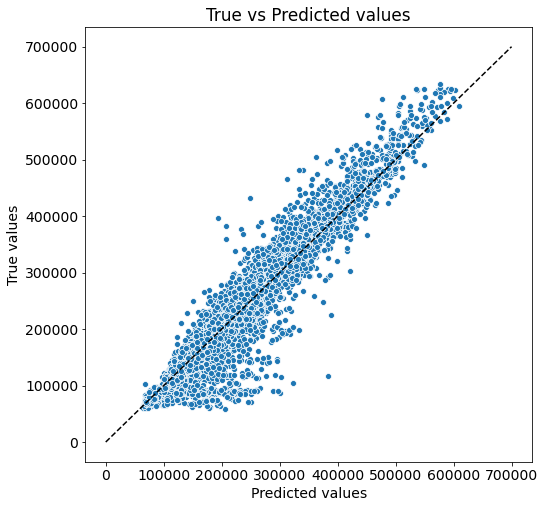

In [317]:
evaluate_preds(y_train, y_train_preds_gb)

In [318]:
y_test_preds_gb = gb_model.predict(test_df)

### КРОСС-ВАЛИДАЦИЯ поиск по сетке параметров

In [319]:
# gs.best_params_

### Градиентный бустинг на лучших параметрах

In [320]:
gb_best_model = GradientBoostingRegressor(criterion='mse', # критерий по которому идет оценка
                          min_samples_leaf=10, #максимальное количество в листе?????
                          random_state=42,
                         n_estimators=400, # кол-во моделей / кол-во деревьев
                         max_depth=3 # макс глубина
                         )

In [321]:
gb_best_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', min_samples_leaf=10,
                          n_estimators=400, random_state=42)

In [322]:
y_train_preds_gb_best = gb_best_model.predict(X_train)

R2:	0.841
RMSE:	36944.439
MSE:	1364891573.809


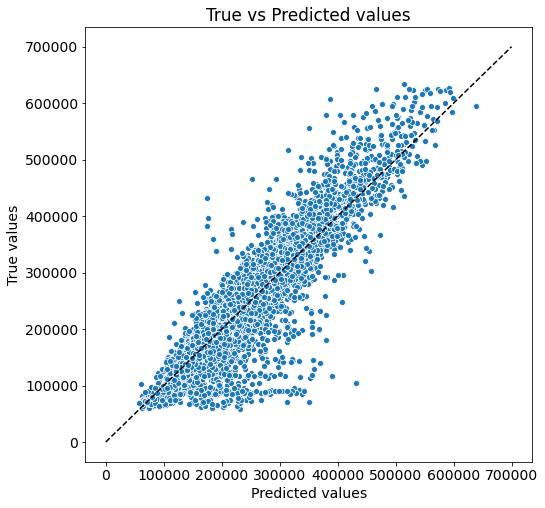

In [323]:
evaluate_preds(y_train, y_train_preds_gb_best)

In [324]:
y_test_preds_gb_best = gb_best_model.predict(test_df)

In [325]:
y_test_preds_gb_best

array([167287.31901792, 125745.97141535, 154178.17838716, ...,
       143596.37417814, 178593.69609909, 283030.12777222])

### Прогнозирование на тестовом датасете

In [326]:
submit = pd.read_csv('C:/Users/Ник/Desktop/Библиотеки Python/Курсовой1/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [327]:
submit['Price'] = y_test_preds_gb_best

In [328]:
submit.to_csv('rf_submit.csv', index=False)

In [329]:
submit_2 = pd.read_csv('C:/Users/Ник/Desktop/Библиотеки Python/Курсовой1/sample_submission.csv')
submit_2.tail(2)

,Id,Price
4998,5722,200000.0
4999,11004,200000.0


In [330]:
submit_2['Price'] = y_test_preds_gb

In [331]:
submit_2.to_csv('rf_submit_2.csv', index=False)